# Personalized Cancer Diagnosis

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from datetime import datetime
from tqdm._tqdm_notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from collections import Counter, defaultdict
import math
from sklearn.preprocessing import normalize
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from bs4 import BeautifulSoup
from prettytable import PrettyTable
tqdm_notebook.pandas()

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 1. Exploratory Data Analysis

## 1.1 Reading Data

### 1.1.1 Reading Gene and Variation Data

In [3]:
data = pd.read_csv("training_variants")
print("Number of data points :", data.shape[0])
print("Number of features :", data.shape[1])
print("Features :", data.columns.values)
data.head()

Number of data points : 3321
Number of features : 4
Features : ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


### 1.1.2 Reading Text Data

In [4]:
data_text = pd.read_csv("training_text", sep = "\|\|", engine = "python", names = ["ID", "TEXT"], 
                                                                          skiprows = 1)
print("Number of data points :", data_text.shape[0])
print("Number of features :", data_text.shape[1])
print("Features :", data_text.columns.values)
data_text.head()

Number of data points : 3321
Number of features : 2
Features : ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


### 1.1.3 Preprocessing of Text

In [5]:
stop_words = set(stopwords.words("english"))

stop_words.update(["mutations", "cell", "cells", "mutation", "fig", "cancer", "figure", 
                                                                       "patients", "also"])
def nlp_preprocessing(total_text):
    if (type(total_text) is not int) and (type(total_text) is not float):
        string = ""
        
        # Replacing special characters with a space
        total_text = re.sub("\W+", " ", total_text)
        # Replacing multiple space with a single space
        total_text = re.sub("\s+", " ", total_text)
        # Replacing html tags with a space
        soup = BeautifulSoup(total_text, "lxml")
        total_text = soup.get_text()
        # Replacing urls with a space
        total_text = re.sub(r"http\S+", " ", total_text)
        # Converting all the characters to lower case
        total_text = total_text.lower()
        
        for word in total_text.split():
            if word not in stop_words:
                string += word + " "
    
        return string
    return ""

In [6]:
start = datetime.now()
tqdm_notebook.pandas()
data_text["TEXT"] = data_text["TEXT"].progress_apply(nlp_preprocessing)
print("Time taken to run this cell :", datetime.now() - start)
data_text.head()


Time taken to run this cell : 0:00:56.138869


,ID,TEXT
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small lung nsclc heter...
2,2,abstract background non small lung nsclc heter...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic monomeric casitas b lineage lymphoma...


In [7]:
result = pd.merge(data, data_text, on ="ID", how = "left")
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small lung nsclc heter...
2,2,CBL,Q249E,2,abstract background non small lung nsclc heter...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic monomeric casitas b lineage lymphoma...


In [8]:
result[result.isnull().any(1)]

,ID,Gene,Variation,Class,TEXT


In [9]:
result[result["TEXT"] == ""]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,
1277,1277,ARID5B,Truncating Mutations,1,
1407,1407,FGFR3,K508M,6,
1639,1639,FLT1,Amplification,6,
2755,2755,BRAF,G596C,7,


In [10]:
result.loc[result["TEXT"] == "", "TEXT"] = result["Gene"]+" "+result["Variation"]

In [11]:
result[result["ID"] == 1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


### 1.1.4. Test, Train and Cross Validation Split

#### 1.1.4.1. Splitting data into train, test and cross validation (64:20:16)

In [12]:
y_true = result["Class"].values
result.Gene = result.Gene.str.replace("\s+", "_")
result.Variation = result.Variation.str.replace("\s+", "_")

x_train, test_df, y_train, y_test = train_test_split(result, y_true, 
                                                     stratify = y_true, test_size = 0.15)
train_df, cv_df, y_train, y_cv = train_test_split(x_train, y_train, 
                                                  stratify = y_train, test_size = 0.15)

In [13]:
print("Number of points in train data", train_df.shape[0])
print("Number of data points in test data", test_df.shape[0])
print("Number of data points in cross validation data", cv_df.shape[0])

Number of points in train data 2398
Number of data points in test data 499
Number of data points in cross validation data 424


#### 1.1.4.2. Distribution of y_i's in Train, Test and Cross Validation datasets

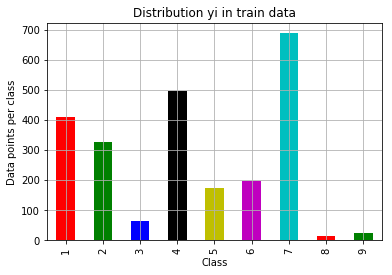

Number of data points in class 7 : 688 ( 28.691 %)
Number of data points in class 4 : 495 ( 20.642 %)
Number of data points in class 1 : 411 ( 17.139 %)
Number of data points in class 2 : 326 ( 13.595 %)
Number of data points in class 6 : 199 ( 8.299 %)
Number of data points in class 5 : 175 ( 7.298 %)
Number of data points in class 3 : 64 ( 2.669 %)
Number of data points in class 9 : 26 ( 1.084 %)
Number of data points in class 8 : 14 ( 0.584 %)
--------------------------------------------------------------------------------


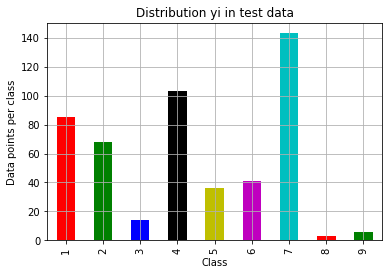

Number of data points in class 7 : 143 ( 28.657 %)
Number of data points in class 4 : 103 ( 20.641 %)
Number of data points in class 1 : 85 ( 17.034 %)
Number of data points in class 2 : 68 ( 13.627 %)
Number of data points in class 6 : 41 ( 8.216 %)
Number of data points in class 5 : 36 ( 7.214 %)
Number of data points in class 3 : 14 ( 2.806 %)
Number of data points in class 9 : 6 ( 1.202 %)
Number of data points in class 8 : 3 ( 0.601 %)
--------------------------------------------------------------------------------


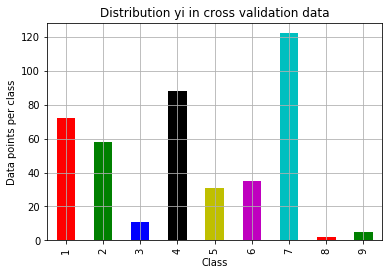

Number of data points in class 7 : 122 ( 28.774 %)
Number of data points in class 4 : 88 ( 20.755 %)
Number of data points in class 1 : 72 ( 16.981 %)
Number of data points in class 2 : 58 ( 13.679 %)
Number of data points in class 6 : 35 ( 8.255 %)
Number of data points in class 5 : 31 ( 7.311 %)
Number of data points in class 3 : 11 ( 2.594 %)
Number of data points in class 9 : 5 ( 1.179 %)
Number of data points in class 8 : 2 ( 0.472 %)


In [14]:
# value_counts() returns a series object with decreasing order of frequencies of each class
train_class_distribution = train_df["Class"].value_counts().sort_index()
test_class_distribution = test_df["Class"].value_counts().sort_index()
cv_class_distribution = cv_df["Class"].value_counts().sort_index()

my_colors = ["r", "g", "b", "k", "y", "m", "c"]
train_class_distribution.plot(kind = "bar", color = my_colors)
plt.xlabel("Class")
plt.ylabel("Data points per class")
plt.title("Distribution yi in train data")
plt.grid()
plt.show()

# -train_class_distribution.values will make argsort sort train_class_distribution.values 
# in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print("Number of data points in class", i+1, ":", train_class_distribution.values[i], 
          "(", np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), "%)")

print("-"*80)
test_class_distribution.plot(kind = "bar", color = my_colors)
plt.xlabel("Class")
plt.ylabel("Data points per class")
plt.title("Distribution yi in test data")
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print("Number of data points in class", i+1, ":", test_class_distribution.values[i], 
          "(", np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), "%)")

print("-"*80)
cv_class_distribution.plot(kind = "bar", color = my_colors)
plt.xlabel("Class")
plt.ylabel("Data points per class")
plt.title("Distribution yi in cross validation data")
plt.grid()
plt.show()

sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print("Number of data points in class", i+1, ":", cv_class_distribution.values[i], 
          "(", np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), "%)")

## 1.2 Prediction using a 'Random' Model

In [15]:
# Function for plotting confusion matrix
def plot_confusion_matrix(y_true, y_predicted):
    confusion_mat = confusion_matrix(y_true, y_predicted)
    precision_matrix = confusion_mat/confusion_mat.sum(axis = 0)
    recall_matrix = (confusion_mat.T/confusion_mat.sum(axis=1)).T
    
    labels = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    
    print("-"*40, "Confusion matrix", "-"*40)
    plt.figure(figsize = (20, 7))
    sns.heatmap(confusion_mat, annot = True, cmap = "YlGnBu", fmt = "d", xticklabels = labels, 
                                                        yticklabels = labels)
    plt.xlabel("Predicted class")
    plt.ylabel("Actual class")
    plt.show()
    
    print("-"*40, "Precision matrix(Column Sum = 1)", "-"*40)
    plt.figure(figsize = (20, 7))
    sns.heatmap(precision_matrix, annot = True, cmap = "YlGnBu", fmt = ".3f", xticklabels = labels, 
                                                        yticklabels = labels)
    plt.xlabel("Predicted class")
    plt.ylabel("Actual class")
    plt.show()
    
    print("-"*40, "Recall matrix(Row Sum = 1)", "-"*40)
    plt.figure(figsize = (20, 7))
    sns.heatmap(recall_matrix, annot = True, cmap = "YlGnBu", fmt = ".3f", xticklabels = labels, 
                                                        yticklabels = labels)
    plt.xlabel("Predicted class")
    plt.ylabel("Actual class")
    plt.show()

Log loss for cross validation data using a random model is : 2.4543068402364057
Log loss for cross validation data using a random model is : 2.5320208557989776
Log loss for test data using a random model is : 2.553921074842848
---------------------------------------- Confusion matrix ----------------------------------------


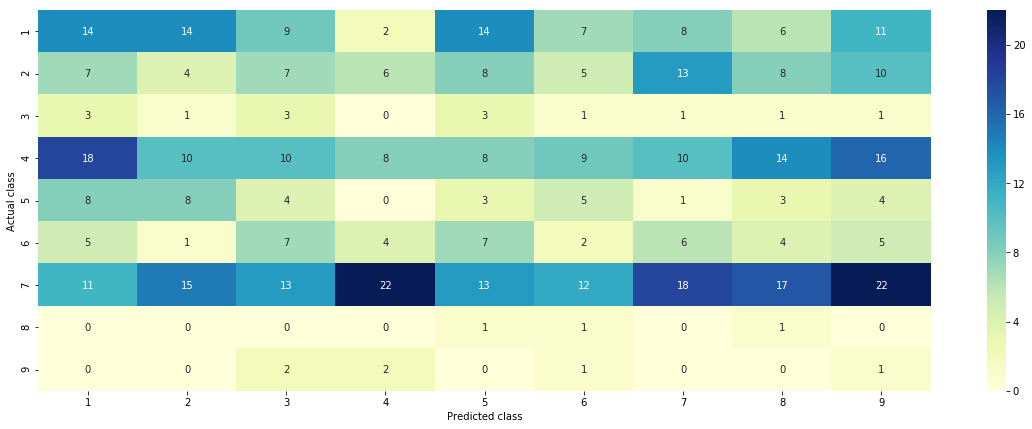

---------------------------------------- Precision matrix(Column Sum = 1) ----------------------------------------


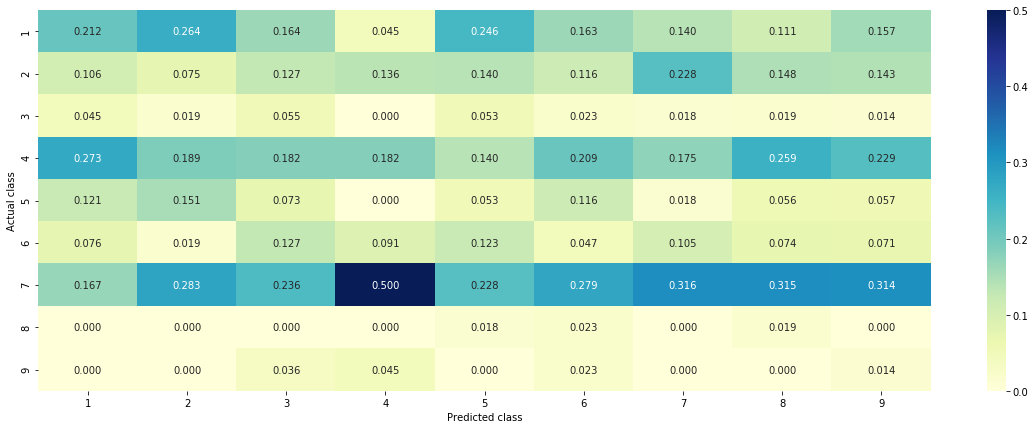

---------------------------------------- Recall matrix(Row Sum = 1) ----------------------------------------


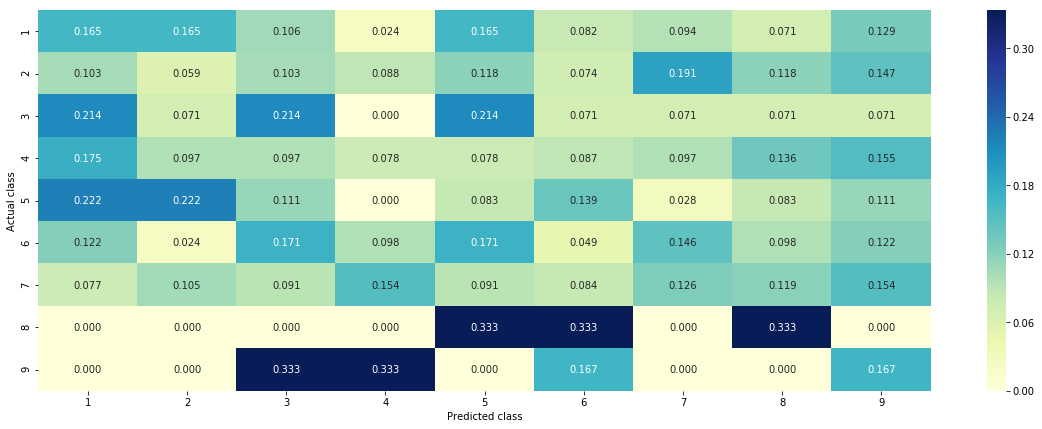

In [16]:
# Random Model
train_data_len = train_df.shape[0]
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

train_predicted_y = np.zeros((train_data_len, 9))
for i in range(len(train_predicted_y)):
    rand_probs = np.random.rand(1, 9)
    train_predicted_y[i] = (rand_probs/sum(sum(rand_probs)))[0] # normalizing so that sum of probabilities is equal to 1
random_train_loss = log_loss(y_train, train_predicted_y)
print("Log loss for cross validation data using a random model is :", random_train_loss)

cv_predicted_y = np.zeros((cv_data_len, 9))
for i in range(len(cv_predicted_y)):
    rand_probs = np.random.rand(1, 9)
    cv_predicted_y[i] = (rand_probs/sum(sum(rand_probs)))[0] # normalizing so that sum of probabilities is equal to 1
random_cv_loss = log_loss(y_cv, cv_predicted_y)
print("Log loss for cross validation data using a random model is :", random_cv_loss)

test_predicted_y = np.zeros((test_data_len, 9))
for i in range(len(test_predicted_y)):
    rand_probs = np.random.rand(1, 9)
    test_predicted_y[i] = (rand_probs/sum(sum(rand_probs)))[0]
random_test_loss = log_loss(y_test, test_predicted_y)                    
print("Log loss for test data using a random model is :", random_test_loss)

y_test_decision_prediction = np.argmax(test_predicted_y, axis = 1)
plot_confusion_matrix(y_test, y_test_decision_prediction + 1)

## 1.3 Univariate Analysis

In [17]:
def get_gv_fea_dict(alpha, feature):
    value_count = train_df[feature].value_counts()
    gv_dict = dict()
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df["Class"] == k) & (train_df[feature] == i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        gv_dict[i] = vec
    return gv_dict

def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature)
    value_count = train_df[feature].value_counts()
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea

### 1.3.1 Univariate Analysis of Gene Feature

<p style="font-size:18px;"> <b>Q1.</b> Gene, What type of feature it is ?</p>
<p style="font-size:16px;"><b>Ans.</b> Gene is a categorical variable </p>
<p style="font-size:18px;"> <b>Q2.</b> How many categories are there and How they are distributed?</p>

In [18]:
unique_genes = train_df["Gene"].value_counts()
print("Number of unique genes ", unique_genes.shape[0])
unique_genes.head(10)

Number of unique genes  242


BRCA1     188
TP53      122
EGFR       99
BRCA2      91
PTEN       87
KIT        74
BRAF       70
ERBB2      50
ALK        50
PIK3CA     41
Name: Gene, dtype: int64

In [19]:
print("There are ", unique_genes.shape[0], "types of different genes and are distributed as follows")

There are  242 types of different genes and are distributed as follows


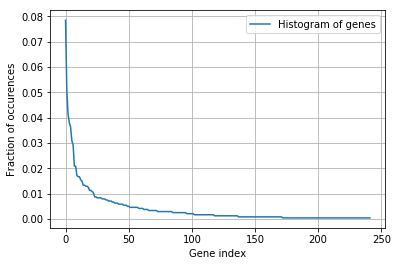

In [20]:
s = sum(unique_genes.values)
h = unique_genes.values/s
plt.plot(h, label = "Histogram of genes")
plt.xlabel("Gene index")
plt.ylabel("Fraction of occurences")
plt.legend()
plt.grid()
plt.show()

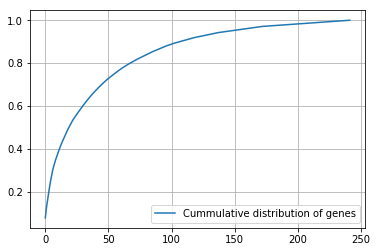

In [21]:
c = np.cumsum(h)
plt.plot(c, label = "Cummulative distribution of genes")
plt.grid()
plt.legend()
plt.show()

<p style="font-size:18px;"> <b>Q3.</b> How to featurize this Gene feature ?</p>

<p style="font-size:16px;"><b>Ans.</b>there are two ways we can featurize this variable
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will choose the appropriate featurization based on the ML model we use.  For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests. </p>

In [22]:
# response coding of gene feature
alpha = 1
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [23]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:")
print("Shape of Train data", train_gene_feature_responseCoding.shape)
print("Shape of Test data", test_gene_feature_responseCoding.shape)
print("Shape of Cross Validation data", cv_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:
Shape of Train data (2398, 9)
Shape of Test data (499, 9)
Shape of Cross Validation data (424, 9)


In [24]:
# one hot encoding of gene feature
vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = vectorizer.fit_transform(train_df["Gene"])
test_gene_feature_onehotCoding = vectorizer.transform(test_df["Gene"])
cv_gene_feature_onehotCoding = vectorizer.transform(cv_df["Gene"])

In [25]:
print("Shape of train data ", train_gene_feature_onehotCoding.shape)
print("Shape of test data ", test_gene_feature_onehotCoding.shape)
print("Shape of cross validation data ", cv_gene_feature_onehotCoding.shape)

Shape of train data  (2398, 241)
Shape of test data  (499, 241)
Shape of cross validation data  (424, 241)


<p style="font-size:18px;"> <b>Q4.</b> How good is this gene feature  in predicting y_i?</p>
There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

Log loss for alpha = 1e-05 is 1.3407636039829818
Log loss for alpha = 0.0001 is 1.166021084281899
Log loss for alpha = 0.001 is 1.1668009269628188
Log loss for alpha = 0.01 is 1.305879686839998
Log loss for alpha = 0.1 is 1.4294355000926533
Log loss for alpha = 1 is 1.4642451354438977


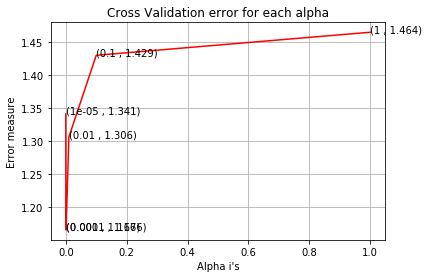

For values of best alpha =  0.0001 The train log loss is: 0.9711187660132259
For values of best alpha =  0.0001 The cross validation log loss is: 1.1877391491806462
For values of best alpha =  0.0001 The test log loss is: 1.2397364798364914


In [26]:
alpha = [10**i for i in range(-5, 1)]
cv_log_error_array = []
for a in alpha:
    clf = SGDClassifier(alpha = a, penalty = "l2", loss = "log")
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sgm_clf = CalibratedClassifierCV(clf, method = "sigmoid", cv = "prefit")
    sgm_clf.fit(train_gene_feature_onehotCoding, y_train)
    predicted_y = sgm_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predicted_y, labels = clf.classes_))
    print("Log loss for alpha =", a,"is", log_loss(y_cv, predicted_y, labels = clf.classes_))
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c = "r")
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate(s = "({} , {})".format(alpha[i], txt), xy = (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.title("Cross Validation error for each alpha")
plt.show()

index = np.argmin(cv_log_error_array)
best_alpha_gene = alpha[index]
best_alpha = alpha[index]
clf_optimal = SGDClassifier(alpha = best_alpha, penalty = "l2", loss = "log")
clf_optimal.fit(train_gene_feature_onehotCoding, y_train)
sgm_clf_optimal = CalibratedClassifierCV(clf_optimal, method = "sigmoid", cv = "prefit")
sgm_clf_optimal.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sgm_clf_optimal.predict_proba(train_gene_feature_onehotCoding)
gene_train_loss = log_loss(y_train, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[index], "The train log loss is:", gene_train_loss)
predict_y = sgm_clf_optimal.predict_proba(cv_gene_feature_onehotCoding)
gene_cv_loss = log_loss(y_cv, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[index], "The cross validation log loss is:", gene_cv_loss)
predict_y = sgm_clf_optimal.predict_proba(test_gene_feature_onehotCoding)
gene_test_loss = log_loss(y_test, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[index], "The test log loss is:", gene_test_loss)

<p style="font-size:18px;"> <b>Q5.</b> Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error. </p>

In [27]:
print("Q6. How many data points in Test and CV datasets are covered by the ", 
                                          unique_genes.shape[0], " genes in train dataset?")

test_coverage = test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage = cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",
                                                          (test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,
                                                              (cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  242  genes in train dataset?
Ans
1. In test data 484 out of 499 : 96.9939879759519
2. In cross validation data 416 out of  424 : 98.11320754716981


### 1.3.2 Univariate Analysis of Variation Feature

<p style="font-size:18px;"> <b>Q7.</b> Variation, What type of feature is it ?</p>
<p style="font-size:16px;"><b>Ans.</b> Variation is a categorical variable </p>
<p style="font-size:18px;"> <b>Q8.</b> How many categories are there?</p>

In [28]:
unique_variations = train_df["Variation"].value_counts()
print("Number of unique variations", unique_variations.shape[0])
print(unique_variations.head(10))

Number of unique variations 2176
Truncating_Mutations    67
Amplification           51
Deletion                50
Fusions                 27
Overexpression           4
G12V                     3
G67R                     2
R841K                    2
Q209L                    2
A146T                    2
Name: Variation, dtype: int64


In [29]:
print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)

Ans: There are 2176 different categories of variations in the train data, and they are distibuted as follows


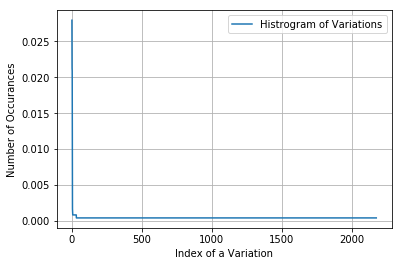

In [30]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02793995 0.04920767 0.07005838 ... 0.99916597 0.99958299 1.        ]


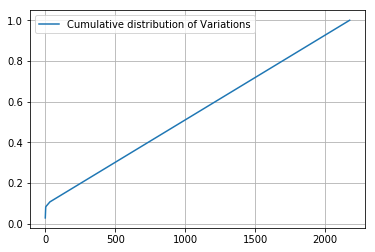

In [31]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

<p style="font-size:18px;"> <b>Q9.</b> How to featurize this Variation feature ?</p>

<p style="font-size:16px;"><b>Ans.</b>There are two ways we can featurize this variable
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will be using both these methods to featurize the Variation Feature </p>

In [32]:
# response coding for variation feature
alpha = 1
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [33]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:")
print("Shape of Train data", train_variation_feature_responseCoding.shape)
print("Shape of Test data", test_variation_feature_responseCoding.shape)
print("Shape of Cross Validation data", cv_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:
Shape of Train data (2398, 9)
Shape of Test data (499, 9)
Shape of Cross Validation data (424, 9)


In [34]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [35]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:")
print("Shape of train data ", train_variation_feature_onehotCoding.shape)
print("Shape of test data ", test_variation_feature_onehotCoding.shape)
print("Shape of cross validation data ", cv_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:
Shape of train data  (2398, 2202)
Shape of test data  (499, 2202)
Shape of cross validation data  (424, 2202)


<p style="font-size:18px;"> <b>Q10.</b> How good is this Variation feature  in predicting y_i?</p>

Let's build a model just like the earlier!

For values of alpha =  1e-05 The log loss is: 1.7325710078398
For values of alpha =  0.0001 The log loss is: 1.7156141605187893
For values of alpha =  0.001 The log loss is: 1.7121347672366878
For values of alpha =  0.01 The log loss is: 1.7191332835396713
For values of alpha =  0.1 The log loss is: 1.7231926073740855
For values of alpha =  1 The log loss is: 1.7243855694432155


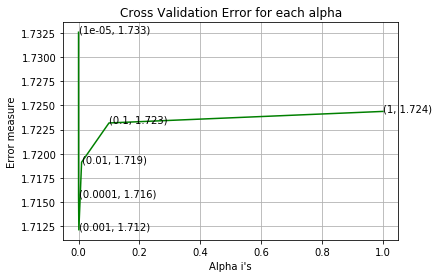

For values of best alpha =  0.001 The train log loss is: 0.21221112682863233
For values of best alpha =  0.001 The cross validation log loss is: 2.234545018372363
For values of best alpha =  0.001 The test log loss is: 2.259203034531463


In [36]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
best_alpha_variation = alpha[best_alpha]
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv = "prefit")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
variation_train_loss = log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", variation_train_loss)
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
variation_cv_loss = log_loss(y_cv, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:", variation_cv_loss)
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
variation_test_loss = log_loss(y_test, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", variation_test_loss)

<p style="font-size:18px;"> <b>Q11.</b> Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Not sure! But lets be very sure using the below analysis. </p>

In [37]:
print("Q12. How many data points are covered by total", unique_variations.shape[0], 
      "genes of train dataset in test and cross validation datasets")
test_coverage = test_df[test_df["Variation"].isin(list(set(train_df["Variation"])))].shape[0]
cv_coverage = cv_df[cv_df["Variation"].isin(list(set(test_df["Variation"])))].shape[0]
print("In test data", test_coverage, "out of", test_df.shape[0], ":", 
      (test_coverage/test_df.shape[0])*100)
print("In cross validation data", cv_coverage, "out of", cv_df.shape[0], ":", 
      (cv_coverage/cv_df.shape[0])*100)

Q12. How many data points are covered by total 2176 genes of train dataset in test and cross validation datasets
In test data 53 out of 499 : 10.62124248496994
In cross validation data 36 out of 424 : 8.49056603773585


### 1.3.3 Univariate Analysis on Text Feature

1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [38]:
# df is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word
def extract_dictionary_paddle(df):
    dictionary = defaultdict(int)
    for index, row in df.iterrows():
        for word in row["TEXT"].split():
            dictionary[word] += 1
    return dictionary

dict_list = []
for i in range(1,10):
    class_df = train_df[train_df["Class"] == i]
    dict_list.append(extract_dictionary_paddle(class_df))

total_dict = extract_dictionary_paddle(train_df)

In [39]:
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0], 9))
    for i in range(0, 9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row["TEXT"].split():
                sum_prob += math.log((dict_list[i].get(word, 0)+10)/(total_dict.get(word, 0)+90))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row["TEXT"].split()))
            row_index += 1
    return text_feature_responseCoding

In [40]:
# response coding for text feature
train_text_feature_responseCoding = get_text_responsecoding(train_df)
test_text_feature_responseCoding = get_text_responsecoding(test_df)
cv_text_feature_responseCoding = get_text_responsecoding(cv_df)

In [41]:
# we convert each row values such that they sum to 1
train_text_feature_responseCoding = \
(train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis = 1)).T
test_text_feature_responseCoding = \
(test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis = 1)).T
cv_text_feature_responseCoding = \
(cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis = 1)).T

In [42]:
# one hot coding for text feature
vectorizer = TfidfVectorizer(min_df = 3)
train_text_feature_onehotCoding = vectorizer.fit_transform(train_df["TEXT"])
train_text_features = vectorizer.get_feature_names()

In [43]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis = 0)

test_text_feature_onehotCoding = vectorizer.transform(test_df["TEXT"])
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis = 0)

cv_text_feature_onehotCoding = vectorizer.transform(cv_df["TEXT"])
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis = 0)

In [44]:
top_indexes = np.argsort(-vectorizer.idf_)[:10]
print("Top 10 Text feature based on idf values are :")
for index in top_indexes:
    print(train_text_features[index])

Top 10 Text feature based on idf values are :
derange
acetaminophen
fmg
vec_f
koivunen
acetoxymethyl
vdv
sanitaria
fmr1
koga


For values of alpha =  1e-05 The log loss is: 1.2826324159073295
For values of alpha =  0.0001 The log loss is: 1.2216174745837718
For values of alpha =  0.001 The log loss is: 1.091455252575963
For values of alpha =  0.01 The log loss is: 1.2364710396046492
For values of alpha =  0.1 The log loss is: 1.3813424588577168
For values of alpha =  1 The log loss is: 1.6571612546599226


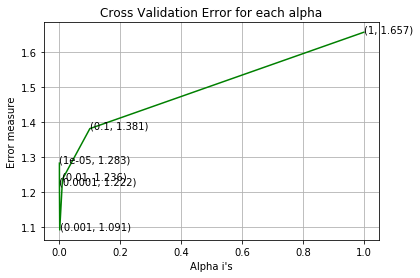

For values of best alpha =  0.001 The train log loss is: 0.6674728910230454
For values of best alpha =  0.001 The cross validation log loss is: 1.091455252575963
For values of best alpha =  0.001 The test log loss is: 1.1645627889959056


In [45]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
best_alpha_text = alpha[best_alpha]
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
text_train_loss = log_loss(y_train, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", text_train_loss)
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
text_cv_loss = log_loss(y_cv, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:", text_cv_loss)
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
text_test_loss = log_loss(y_test, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", text_test_loss)


In [46]:
def get_intersec_text(df):
    vec = TfidfVectorizer(min_df = 3)
    df_matrix = vec.fit_transform(df["TEXT"])
    df_features = vec.get_feature_names()
    len1 = len(df_features)
    len2 = len(set(train_text_features) & set(df_features))
    return len1, len2

In [47]:
len1, len2 = get_intersec_text(test_df)
print((len2/len1)*100,"% of words of test data appeared in train data")

len1, len2 = get_intersec_text(cv_df)
print((len2/len1)*100,"% of words of cross validation data appeared in train data")

99.27550194612509 % of words of test data appeared in train data
99.38450559743099 % of words of cross validation data appeared in train data


# 2. Machine Learning Models

In [48]:
# Data preparation for ML models
def predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid", cv = "prefit")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)
    
    print("Log Loss :", log_loss(test_y, sig_clf.predict_proba(test_x)))
    print("Number of mis-classified points :", np.count_nonzero((pred_y-test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [49]:
def report_log_loss(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid", cv = "prefit")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs)

In [50]:
# Using this function 
# for the given indices, we will print the name of the features
# and we will check whether the feature is present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = TfidfVectorizer(min_df = 3)
    
    gene_count_vec.fit(train_df["Gene"])
    var_count_vec.fit(train_df["Variation"])
    text_count_vec.fit(train_df["TEXT"])
    
    fea1_len = len(gene_count_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    
    for i,v in enumerate(indices):
        if(v < fea1_len):
            word = gene_count_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word, yes_no))
        elif (v < fea1_len + fea2_len):
            word = var_count_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "Variation feature [{}] present in test data point [{}]".format(word, yes_no))
        else:
            word = text_count_vec.get_feature_names()[v-(fea1_len + fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word, yes_no))
    
    print("Out of the top ", no_features, "features", word_present, "are present in query point")

<p style="font-size:24px;text-align:Center"> <b>Stacking the three types of features </b><p>

In [51]:
# here hstack is imported from scipy.sparse not from np
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding, train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding, test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding, cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df["Class"]))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df["Class"]))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df["Class"]))

train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [52]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2398, 62650)
(number of data points * number of features) in test data =  (499, 62650)
(number of data points * number of features) in cross validation data = (424, 62650)


In [53]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2398, 27)
(number of data points * number of features) in test data =  (499, 27)
(number of data points * number of features) in cross validation data = (424, 27)


## 2.1 Base Line Model

### 2.1.1 Naive Bayes

#### 2.1.1.1 Hyper parameter tuning

Log loss for alpha 1e-05 is 1.2186677435558844
Log loss for alpha 0.0001 is 1.209922100921161
Log loss for alpha 0.001 is 1.1991118203581947
Log loss for alpha 0.01 is 1.1868110125472477
Log loss for alpha 0.1 is 1.1992130032301507
Log loss for alpha 1 is 1.2255539216307367
Log loss for alpha 10 is 1.3213244424747679
Log loss for alpha 100 is 1.2461628798860784
Log loss for alpha 1000 is 1.1706423444893967


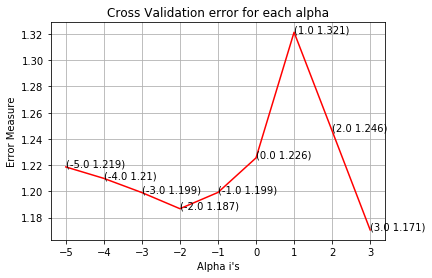

For values of best alpha =  1000 The train log loss is: 0.9374586178349124
For values of best alpha =  1000 The cross validation log loss is: 1.1706423444893967
For values of best alpha =  1000 The test log loss is: 1.3020807981101339


In [54]:
alpha = [10**x for x in range(-5, 4)]
cv_log_error_array = []
for i in alpha:
    clf = MultinomialNB(alpha = i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels = clf.classes_))
    print("Log loss for alpha", i, "is", log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array, c = "r")
for i, text in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate(s = "({} {})".format(np.log10(alpha[i]), text), xy = (np.log10(alpha[i]), cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error Measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
best_alpha_nb = alpha[best_alpha]
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
nb_train_loss = log_loss(y_train, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", nb_train_loss)
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
nb_cv_loss = log_loss(y_cv, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:", nb_cv_loss)
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
nb_test_loss = log_loss(y_test, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", nb_test_loss)

#### 2.1.1.2 Testing the model with best hyper parameters

Log Loss : 1.1706423444893967
%age of misclassified points 39.85849056603774 %
---------------------------------------- Confusion matrix ----------------------------------------


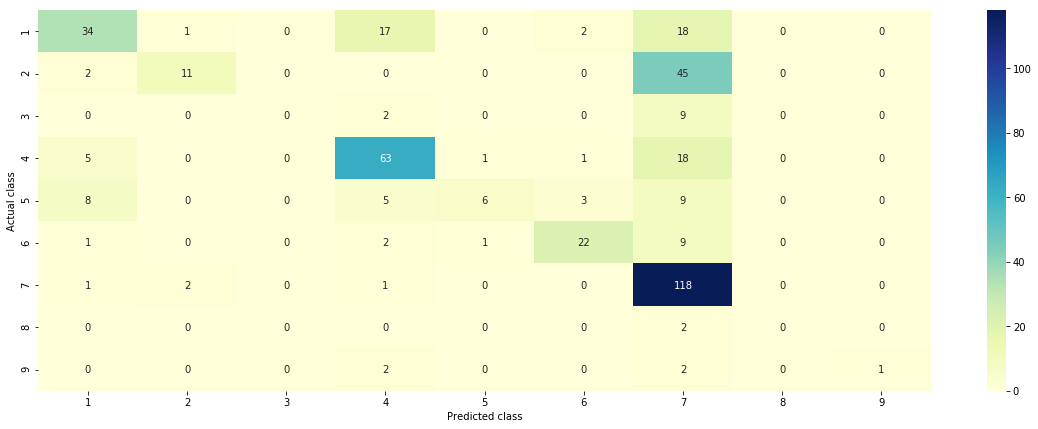

---------------------------------------- Precision matrix(Column Sum = 1) ----------------------------------------


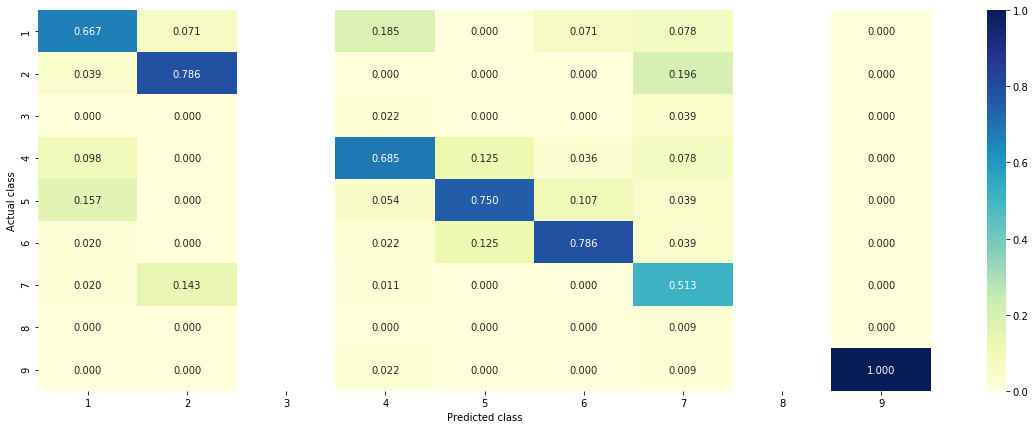

---------------------------------------- Recall matrix(Row Sum = 1) ----------------------------------------


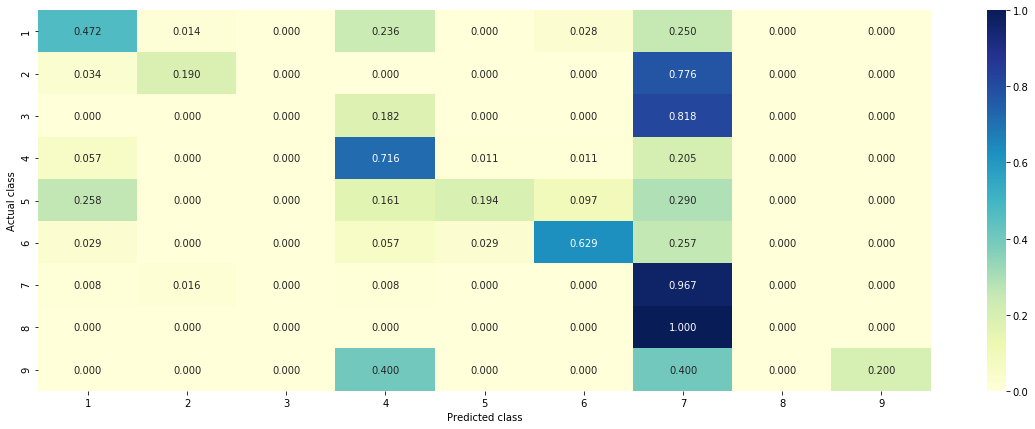

In [55]:
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("%age of misclassified points", 
      np.count_nonzero(sig_clf.predict(cv_x_onehotCoding) - cv_y)*100/cv_y.shape[0], "%")
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding))

#### 2.1.1.3 Feature Importance, Correctly classified point

In [56]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities :", 
      np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index])[0], 3))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df["TEXT"].iloc[test_point_index], 
                     test_df["Gene"].iloc[test_point_index], 
                     test_df["Variation"].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities : [0.007 0.399 0.    0.005 0.008 0.012 0.569 0.    0.   ]
Actual Class : 6
--------------------------------------------------
16 Text feature [kinase] present in test data point [True]
18 Text feature [activation] present in test data point [True]
19 Text feature [presence] present in test data point [True]
21 Text feature [shown] present in test data point [True]
22 Text feature [phosphorylation] present in test data point [True]
24 Text feature [10] present in test data point [True]
25 Text feature [factor] present in test data point [True]
26 Text feature [however] present in test data point [True]
27 Text feature [suggest] present in test data point [True]
30 Text feature [growth] present in test data point [True]
31 Text feature [treated] present in test data point [True]
32 Text feature [similar] present in test data point [True]
33 Text feature [recently] present in test data point [True]
34 Text feature [addition] present in tes

#### 2.1.1.4 Feature Importance, Incorrectly classified point

In [57]:
for i in range(len(test_y)):
    if(test_y[i] != sig_clf.predict(test_x_onehotCoding[i])):
        break
test_point_index = i
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],
                      test_df['Gene'].iloc[test_point_index], 
                     test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[7.200e-03 3.988e-01 3.000e-04 5.200e-03 7.700e-03 1.190e-02 5.686e-01
  3.000e-04 0.000e+00]]
Actual Class : 6
--------------------------------------------------
16 Text feature [kinase] present in test data point [True]
18 Text feature [activation] present in test data point [True]
19 Text feature [presence] present in test data point [True]
21 Text feature [shown] present in test data point [True]
22 Text feature [phosphorylation] present in test data point [True]
24 Text feature [10] present in test data point [True]
25 Text feature [factor] present in test data point [True]
26 Text feature [however] present in test data point [True]
27 Text feature [suggest] present in test data point [True]
30 Text feature [growth] present in test data point [True]
31 Text feature [treated] present in test data point [True]
32 Text feature [similar] present in test data point [True]
33 Text feature [recently] present in test data point [True]
34

## 2.2 K Nearest Neighbour Classification

### 2.2.1 Hyper parameter tuning

for alpha = 5
Log Loss : 1.0400889897424548
for alpha = 11
Log Loss : 1.0114884168720564
for alpha = 15
Log Loss : 1.0402993986953986
for alpha = 21
Log Loss : 1.0574316035485345
for alpha = 31
Log Loss : 1.0770061382762233
for alpha = 41
Log Loss : 1.0839861683419776
for alpha = 51
Log Loss : 1.0870883578831045
for alpha = 99
Log Loss : 1.0792316421620352


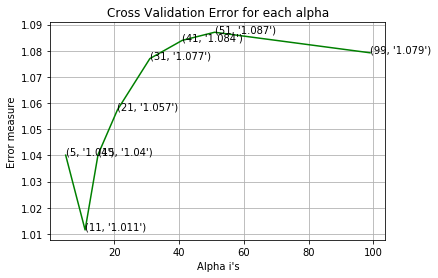

For values of best alpha =  11 The train log loss is: 0.6374394431263133
For values of best alpha =  11 The cross validation log loss is: 1.0114884168720564
For values of best alpha =  11 The test log loss is: 1.020745837445178


In [58]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
best_alpha_knn = alpha[best_alpha]
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
knn_train_loss = log_loss(y_train, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", knn_train_loss)
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
knn_cv_loss = log_loss(y_cv, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:", knn_cv_loss)
predict_y = sig_clf.predict_proba(test_x_responseCoding)
knn_test_loss = log_loss(y_test, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", knn_test_loss)


### 2.2.2. Testing the model with best hyper paramters

Log Loss : 1.0114884168720564
Number of missclassified point : 0.33726415094339623
---------------------------------------- Confusion matrix ----------------------------------------


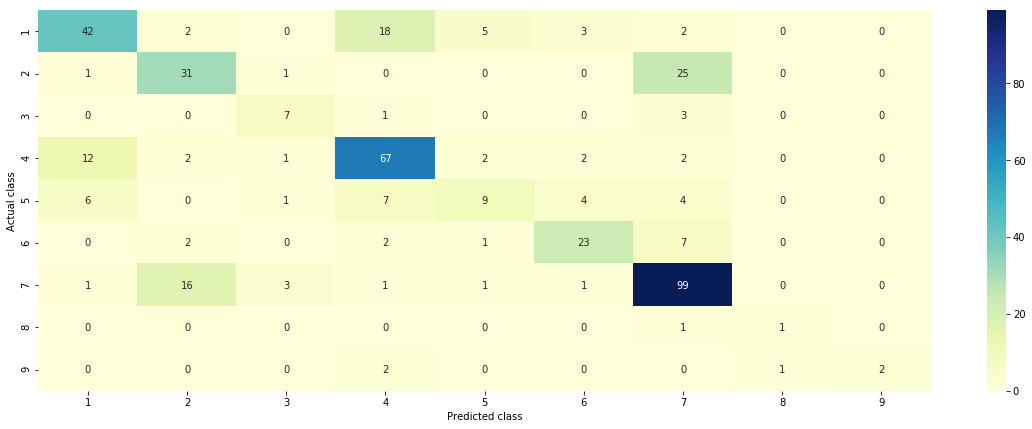

---------------------------------------- Precision matrix(Column Sum = 1) ----------------------------------------


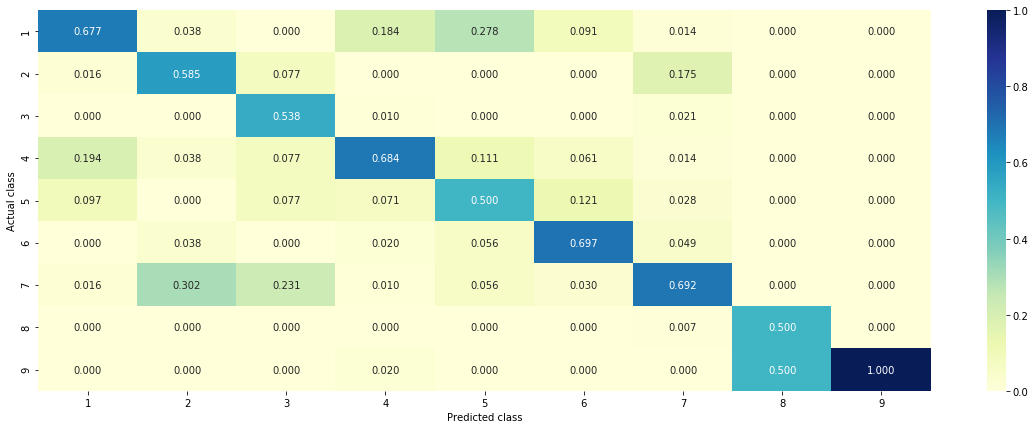

---------------------------------------- Recall matrix(Row Sum = 1) ----------------------------------------


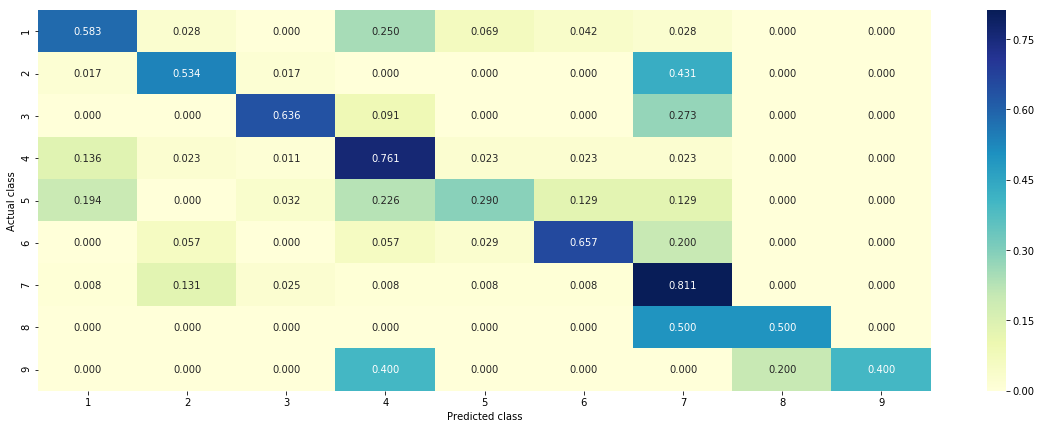

In [59]:
sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", 
      np.count_nonzero((sig_clf.predict(cv_x_responseCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_responseCoding))

### 2.2.3 Sample Query point -1

In [60]:
test_point_index = 1

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1, -1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), 
                           alpha[best_alpha])
print("The", alpha[best_alpha], "nearest neighbours of the test points belongs to classes", 
      train_y[neighbors[1][0]])
print("Frequency of nearest points :", Counter(train_y[neighbors[1][0]]))

Predicted Class : 2
Actual Class : 6
The 11 nearest neighbours of the test points belongs to classes [2 2 2 2 2 2 2 7 2 7 7]
Frequency of nearest points : Counter({2: 8, 7: 3})


### 2.2.4 Sample Query point -2

In [61]:
test_point_index = 33

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1, -1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), 
                           alpha[best_alpha])
print("The", alpha[best_alpha], "nearest neighbors of the test points belongs to classes",
      train_y[neighbors[1][0]])
print("Frequency of nearest points :", Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 4
The 11 nearest neighbors of the test points belongs to classes [1 4 1 1 4 1 4 1 4 3 4]
Frequency of nearest points : Counter({1: 5, 4: 5, 3: 1})


## 2.3 Logistic Regression

### 2.3.1 With Class balancing

#### 2.3.1.1 Hyper parameter tuning

for alpha = 1e-06
Log Loss : 1.2923630810010802
for alpha = 1e-05
Log Loss : 1.3722515730241256
for alpha = 0.0001
Log Loss : 1.1918403922207679
for alpha = 0.001
Log Loss : 0.934719235894929
for alpha = 0.01
Log Loss : 1.2414328877079364
for alpha = 0.1
Log Loss : 1.7192525161275387
for alpha = 1
Log Loss : 1.8277571951264497
for alpha = 10
Log Loss : 1.8277571951258031
for alpha = 100
Log Loss : 1.8277571951257727


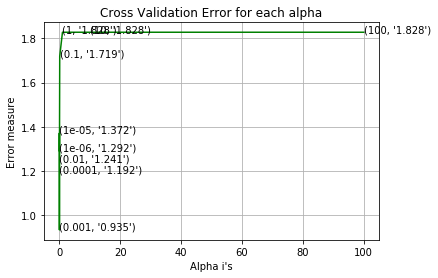

For values of best alpha =  0.001 The train log loss is: 0.5752391605761653
For values of best alpha =  0.001 The cross validation log loss is: 1.0652465483475304
For values of best alpha =  0.001 The test log loss is: 1.1030966196044447


In [62]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='elasticnet', loss='log')
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
best_alpha_b_log = alpha[best_alpha]
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
log_b_train_loss = log_loss(y_train, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_b_train_loss)
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
log_b_cv_loss = log_loss(y_cv, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:", log_b_cv_loss)
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
log_b_test_loss = log_loss(y_test, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_b_test_loss)

#### 2.3.1.2. Testing the model with best hyper paramters

Log Loss : 1.0652465483475304
Number of missclassified point : 0.330188679245283
---------------------------------------- Confusion matrix ----------------------------------------


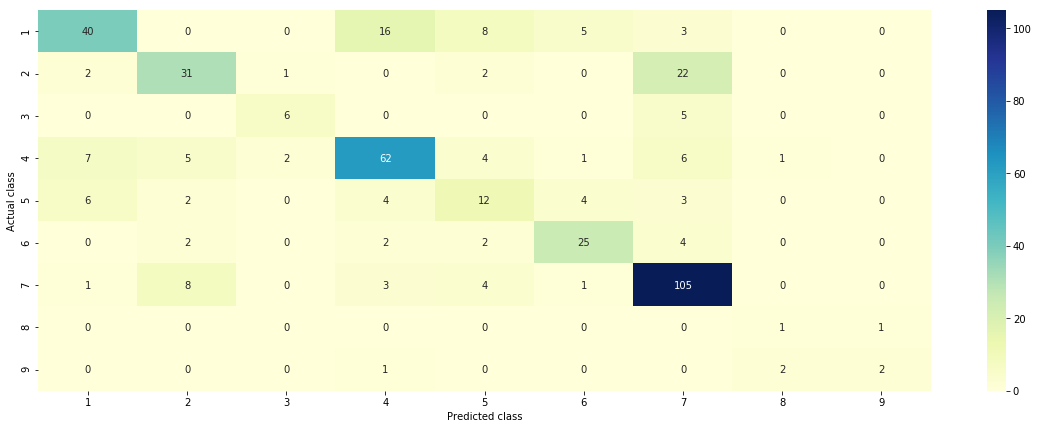

---------------------------------------- Precision matrix(Column Sum = 1) ----------------------------------------


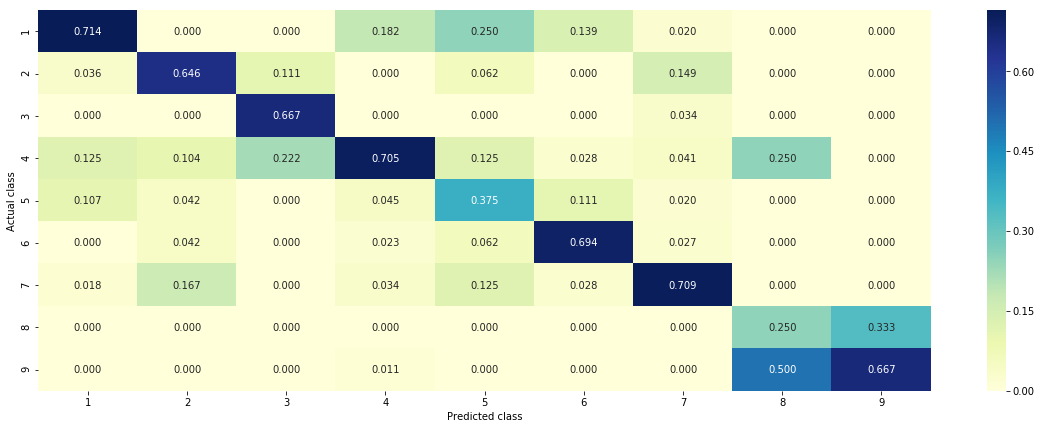

---------------------------------------- Recall matrix(Row Sum = 1) ----------------------------------------


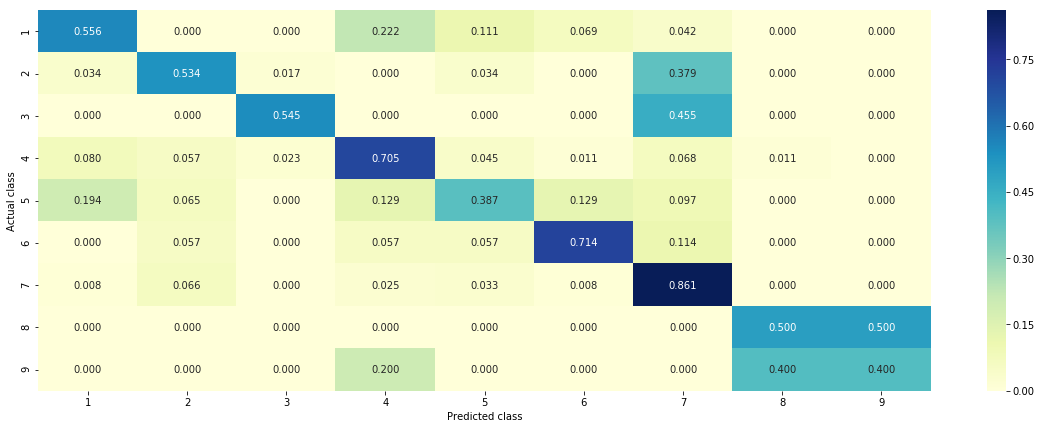

In [63]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", 
      np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding))

#### 2.3.1.3. Feature Importance

##### 2.3.1.3.1 Correctly Classifier point

In [64]:
for i in range(len(test_y)):
    if test_y[i] == sig_clf.predict(test_x_onehotCoding[i]):
        break
test_point_index = i
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted class probabilities :", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]), 4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls - 1][:,:no_feature]
print("-"*80)
get_impfeature_names(indices[0],  test_df["TEXT"].iloc[test_point_index], 
                     test_df["Gene"].iloc[test_point_index], 
                     test_df["Variation"].iloc[test_point_index], 
                     no_feature)

Predicted Class : 4
Predicted class probabilities : [[0.0007 0.0024 0.3246 0.5402 0.0975 0.0245 0.0006 0.0075 0.0021]]
Actual Class : 4
--------------------------------------------------------------------------------
73 Text feature [leu86ala] present in test data point [True]
74 Text feature [bard] present in test data point [True]
75 Text feature [agreeing] present in test data point [True]
76 Text feature [ile90ala] present in test data point [True]
77 Text feature [r507i] present in test data point [True]
78 Text feature [krkrfull] present in test data point [True]
79 Text feature [neswt] present in test data point [True]
80 Text feature [œprimarilyâ] present in test data point [True]
81 Text feature [nesmut] present in test data point [True]
Out of the top  100 features 9 are present in query point


##### 2.3.1.3.2 Incorrectly Classified point

In [65]:
for i in range(len(test_y)):
    if test_y[i] != sig_clf.predict(test_x_onehotCoding[i]):
        break
test_point_index = i
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted class probabilities :", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]), 4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls - 1][:,:no_feature]
print("-"*80)
get_impfeature_names(indices[0],  test_df["TEXT"].iloc[test_point_index], 
                     test_df["Gene"].iloc[test_point_index], 
                     test_df["Variation"].iloc[test_point_index], 
                     no_feature)

Predicted Class : 2
Predicted class probabilities : [[0.0059 0.8224 0.0028 0.0023 0.0095 0.0045 0.147  0.0031 0.0025]]
Actual Class : 6
--------------------------------------------------------------------------------
Out of the top  100 features 0 are present in query point


Below is the 3rd point of assignment

In [66]:
vect = CountVectorizer(min_df = 3, ngram_range = (1, 2), max_features = 1500)
vect.fit(train_df["TEXT"])
train_x = vect.transform(train_df["TEXT"])
train_x = hstack((train_gene_var_onehotCoding, train_x)).tocsr()
test_x = vect.transform(test_df["TEXT"])
test_x = hstack((test_gene_var_onehotCoding, test_x)).tocsr()
cv_x = vect.transform(cv_df["TEXT"])
cv_x = hstack((cv_gene_var_onehotCoding, cv_x)).tocsr()

In [67]:
print("Train Data Shape :", train_x.shape)
print("Test Data Shape :", test_x.shape)
print("Cross Validation Data Shape :", cv_x.shape)

Train Data Shape : (2398, 3943)
Test Data Shape : (499, 3943)
Cross Validation Data Shape : (424, 3943)


for alpha = 0.0001
Log Loss : 1.4221438793822732
for alpha = 0.001
Log Loss : 1.3756117669020038
for alpha = 0.01
Log Loss : 1.406274552482285
for alpha = 0.1
Log Loss : 1.3773165069307252
for alpha = 1
Log Loss : 1.3598116788416985
for alpha = 10
Log Loss : 1.218274624737676
for alpha = 100
Log Loss : 1.3184708571650567
for alpha = 1000
Log Loss : 1.6529071156689936
for alpha = 10000
Log Loss : 1.7978887835939303
for alpha = 100000
Log Loss : 1.8114737178687488


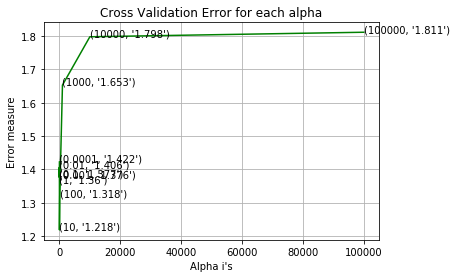

For values of best alpha =  10 The train log loss is: 1.1140962878641287
For values of best alpha =  10 The cross validation log loss is: 1.226528903988946
For values of best alpha =  10 The test log loss is: 1.257821210952472


In [68]:
alpha = [10 ** x for x in range(-4, 6)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log')
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
best_alpha_log_bow = alpha[best_alpha]
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

predict_y = sig_clf.predict_proba(train_x)
log_bow_train_loss = log_loss(y_train, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_bow_train_loss)
predict_y = sig_clf.predict_proba(cv_x)
log_bow_cv_loss = log_loss(y_cv, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:", log_bow_cv_loss)
predict_y = sig_clf.predict_proba(test_x)
log_bow_test_loss = log_loss(y_test, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_bow_test_loss)

Log Loss : 1.226528903988946
Number of missclassified point : 0.4268867924528302
---------------------------------------- Confusion matrix ----------------------------------------


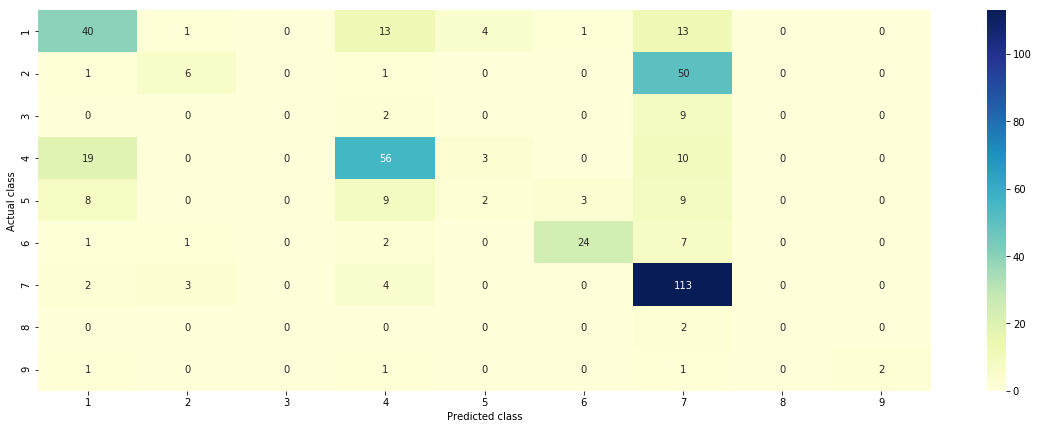

---------------------------------------- Precision matrix(Column Sum = 1) ----------------------------------------


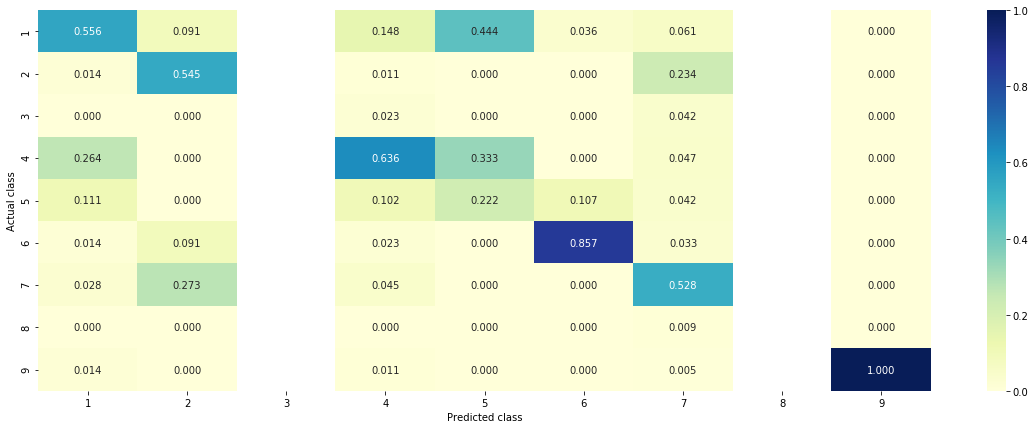

---------------------------------------- Recall matrix(Row Sum = 1) ----------------------------------------


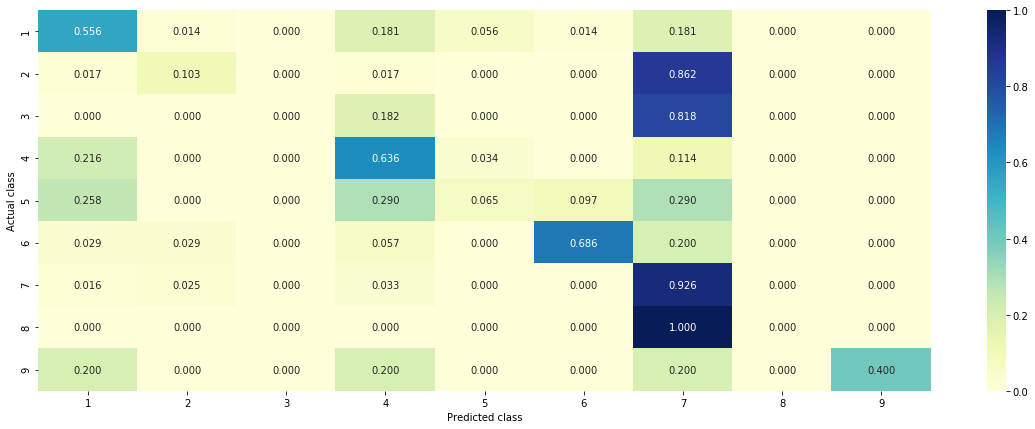

In [69]:
sig_clf_probs = sig_clf.predict_proba(cv_x)
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", 
      np.count_nonzero((sig_clf.predict(cv_x)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x))

### 2.3.2 Without Class Balancing

#### 2.3.2.1 Hyperparameter tuning

for alpha = 1e-06
Log Loss : 1.2847953834889805
for alpha = 1e-05
Log Loss : 1.2901278611635507
for alpha = 0.0001
Log Loss : 1.234290911726759
for alpha = 0.001
Log Loss : 1.0737371967618625
for alpha = 0.01
Log Loss : 1.1824297316554306
for alpha = 0.1
Log Loss : 1.3226357739971812
for alpha = 1
Log Loss : 1.6051635277780474


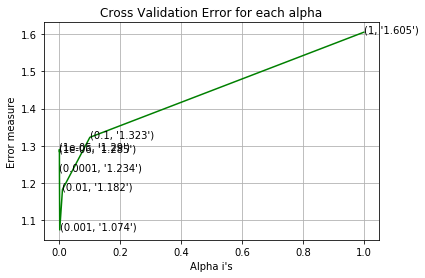

For values of best alpha =  0.001 The train log loss is: 0.5684372622486691
For values of best alpha =  0.001 The cross validation log loss is: 1.0737371967618625
For values of best alpha =  0.001 The test log loss is: 1.1419687464853585


In [70]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
best_alpha_log = alpha[best_alpha]
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
log_train_loss = log_loss(y_train, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_train_loss)
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
log_cv_loss = log_loss(y_cv, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:", log_cv_loss)
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
log_test_loss = log_loss(y_test, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_test_loss)

#### 2.3.2.2. Testing model with best hyper parameters

Log Loss : 1.0737371967618625
Number of missclassified point : 0.3419811320754717
---------------------------------------- Confusion matrix ----------------------------------------


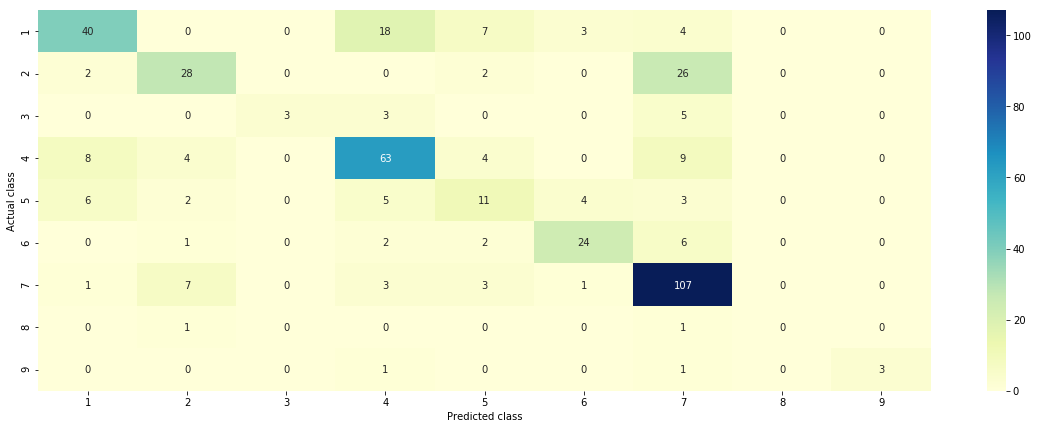

---------------------------------------- Precision matrix(Column Sum = 1) ----------------------------------------


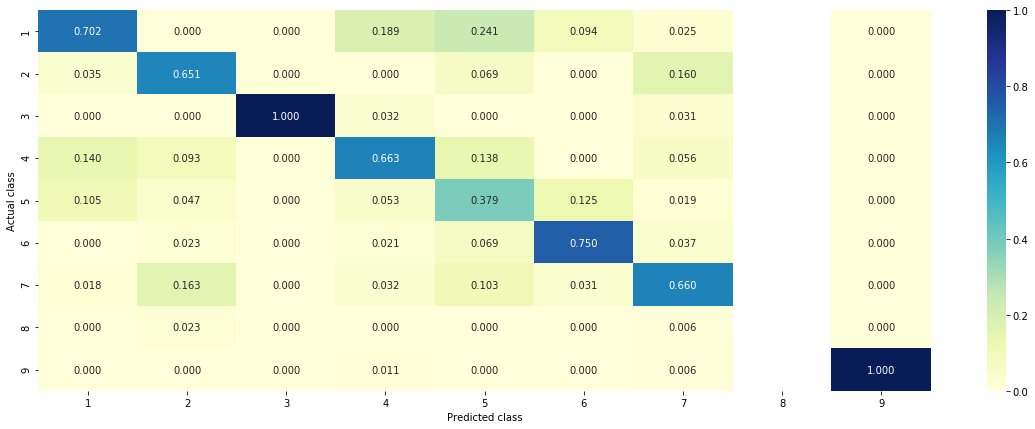

---------------------------------------- Recall matrix(Row Sum = 1) ----------------------------------------


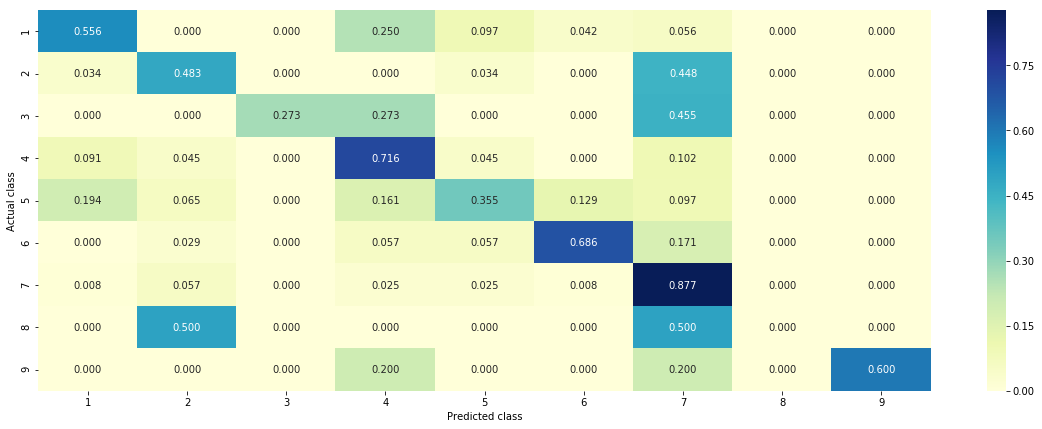

In [71]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", 
      np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding))

#### 2.3.2.3 Feature Importance, Correctly Classified Point

In [72]:
for i in range(len(test_y)):
    if test_y[i] == sig_clf.predict(test_x_onehotCoding[i]):
        break
test_point_index = i
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], 
                     test_df['TEXT'].iloc[test_point_index],
                     test_df['Gene'].iloc[test_point_index],
                     test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0016 0.0032 0.0827 0.8396 0.041  0.0236 0.0024 0.0059 0.    ]]
Actual Class : 4
--------------------------------------------------
Out of the top  100 features 0 are present in query point


#### 2.3.2.4  Feature Importance, Inorrectly Classified point

In [73]:
for i in range(len(test_y)):
    if test_y[i] != sig_clf.predict(test_x_onehotCoding[i]):
        break
test_point_index = i
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], 
                     test_df['TEXT'].iloc[test_point_index],
                     test_df['Gene'].iloc[test_point_index],
                     test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[8.100e-03 8.256e-01 6.000e-04 3.200e-03 7.100e-03 4.100e-03 1.473e-01
  4.000e-03 1.000e-04]]
Actual Class : 6
--------------------------------------------------
Out of the top  100 features 0 are present in query point


## 2.4. Linear Support Vector Machines

### 2.4.1 Hyper parameter tuning

for C = 1e-05
Log Loss : 1.3021135462398634
for C = 0.0001
Log Loss : 1.2647071234196907
for C = 0.001
Log Loss : 1.1030363310529534
for C = 0.01
Log Loss : 1.061782302718011
for C = 0.1
Log Loss : 1.2927279252959696
for C = 1
Log Loss : 1.493411680865496
for C = 10
Log Loss : 1.4924947000202156
for C = 100
Log Loss : 1.4924946836251092


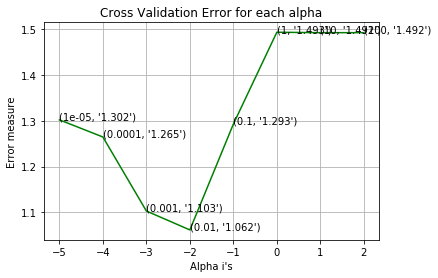

For values of best alpha =  0.01 The train log loss is: 0.7241815917908772
For values of best alpha =  0.01 The cross validation log loss is: 1.061782302718011
For values of best alpha =  0.01 The test log loss is: 1.1230763868124207


In [74]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#   clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i], str(txt)), (np.log10(alpha[i]), cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
best_alpha_svm = alpha[best_alpha]
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
svm_train_loss = log_loss(y_train, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", svm_train_loss)
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
svm_cv_loss = log_loss(y_cv, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:", svm_cv_loss)
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
svm_test_loss = log_loss(y_test, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", svm_test_loss)

### 2.4.2 Testing model with best hyper parameters

Log Loss : 1.061782302718011
Number of missclassified point : 0.3278301886792453
---------------------------------------- Confusion matrix ----------------------------------------


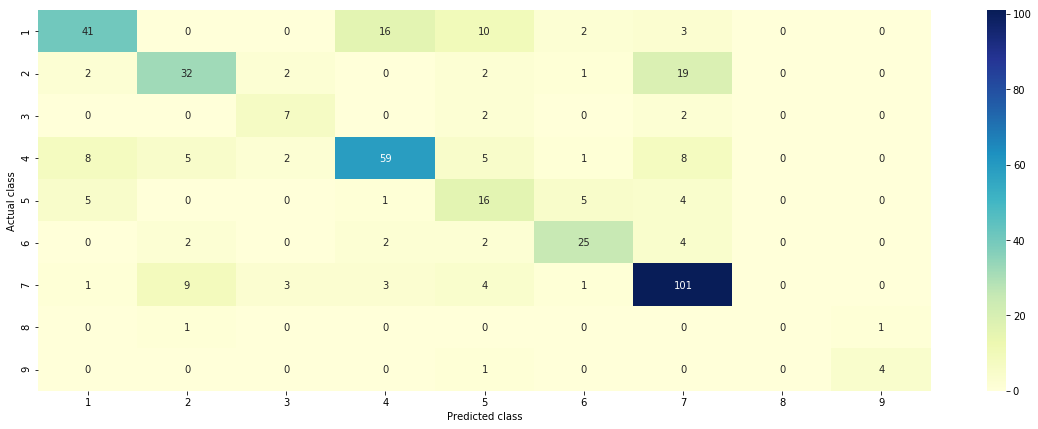

---------------------------------------- Precision matrix(Column Sum = 1) ----------------------------------------


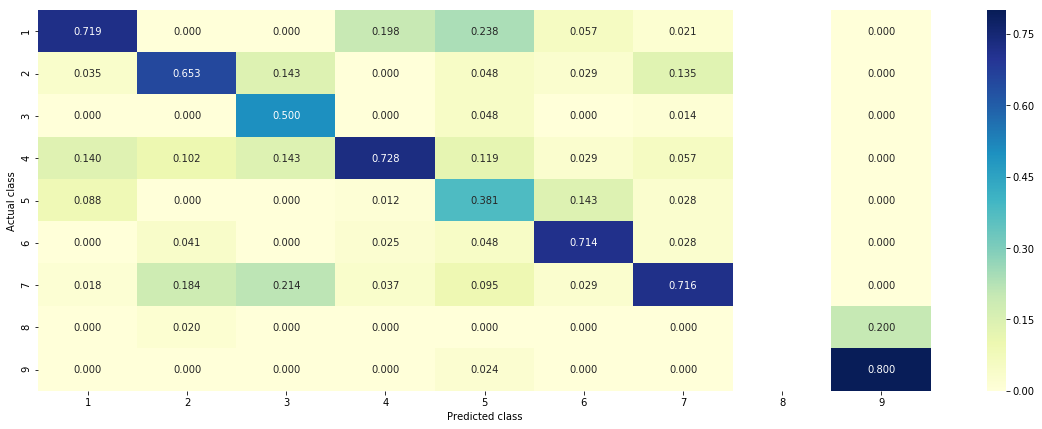

---------------------------------------- Recall matrix(Row Sum = 1) ----------------------------------------


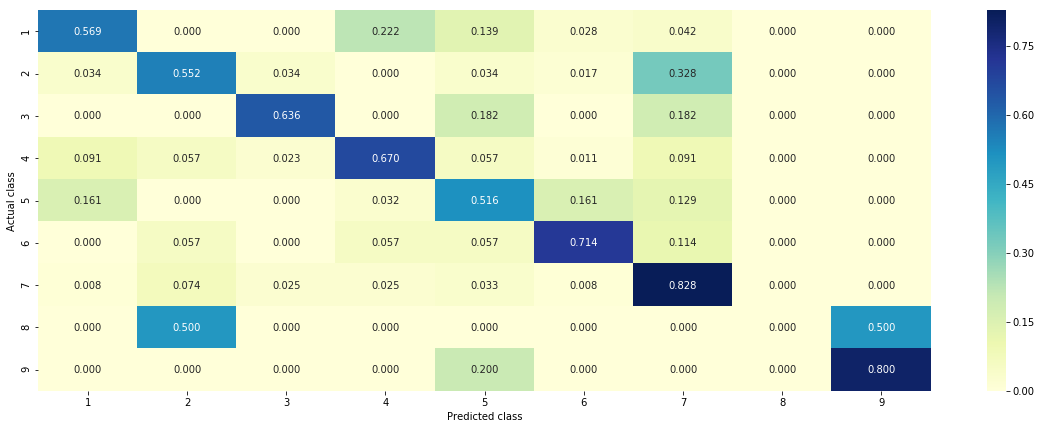

In [75]:
clf = SGDClassifier(class_weight = "balanced", alpha=alpha[best_alpha], penalty='l2', 
                    loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", 
      np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding))

### 2.3.3 Feature Importance

#### 2.3.3.1 For Correctly Classified Point

In [76]:
for i in range(len(test_y)):
    if test_y[i] == sig_clf.predict(test_x_onehotCoding[i]):
        break
test_point_index = i
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],
                     test_df['Gene'].iloc[test_point_index],
                     test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 5
Predicted Class Probabilities: [[0.1924 0.0762 0.0125 0.0994 0.4779 0.0045 0.1146 0.0168 0.0057]]
Actual Class : 5
--------------------------------------------------
Out of the top  500 features 0 are present in query point


#### 2.3.3.2 For Incorrectly Classified Point

In [77]:
for i in range(len(test_y)):
    if test_y[i] != sig_clf.predict(test_x_onehotCoding[i]):
        break
test_point_index = i
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],
                     test_df['Gene'].iloc[test_point_index],
                     test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 3
Predicted Class Probabilities: [[0.0067 0.0163 0.4794 0.1711 0.2798 0.0269 0.0094 0.0091 0.0013]]
Actual Class : 4
--------------------------------------------------
70 Text feature [1706] present in test data point [True]
90 Text feature [distress] present in test data point [True]
94 Text feature [saâ] present in test data point [True]
95 Text feature [prespliced] present in test data point [True]
96 Text feature [helaâ] present in test data point [True]
97 Text feature [cotta] present in test data point [True]
98 Text feature [e143k] present in test data point [True]
99 Text feature [ramusino] present in test data point [True]
100 Text feature [vexing] present in test data point [True]
101 Text feature [v191d] present in test data point [True]
102 Text feature [quandary] present in test data point [True]
103 Text feature [vallee] present in test data point [True]
104 Text feature [nondepleted] present in test data point [True]
105 Text feature [misclassify] prese

## 2.5 Random Forest Classifier

### 2.5.1 Hyper paramter tuning (With One hot Encoding)

In [78]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
        
best_alpha = np.argmin(cv_log_error_array)
best_n_estimators_rf_onehot = alpha[int(best_alpha/2)]
best_max_depth_rf_onehot = max_depth[int(best_alpha%2)]
clf = RandomForestClassifier(n_estimators = alpha[int(best_alpha/2)], criterion='gini', 
                             max_depth=max_depth[int(best_alpha%2)], n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
rf_onehot_train_loss = log_loss(y_train, predict_y, labels=clf.classes_)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:", rf_onehot_train_loss)
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
rf_onehot_cv_loss = log_loss(y_cv, predict_y, labels=clf.classes_)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:", rf_onehot_cv_loss)
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
rf_onehot_test_loss = log_loss(y_test, predict_y, labels=clf.classes_)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:", rf_onehot_test_loss)

for n_estimators = 100 and max depth =  5
Log Loss : 1.1924232451773922
for n_estimators = 100 and max depth =  10
Log Loss : 1.1286301773790925
for n_estimators = 200 and max depth =  5
Log Loss : 1.1720428026336862
for n_estimators = 200 and max depth =  10
Log Loss : 1.1335863600352671
for n_estimators = 500 and max depth =  5
Log Loss : 1.1718933734308628
for n_estimators = 500 and max depth =  10
Log Loss : 1.1228147461991584
for n_estimators = 1000 and max depth =  5
Log Loss : 1.167704957301132
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1206962468091515
for n_estimators = 2000 and max depth =  5
Log Loss : 1.164932335081181
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1273294455666447
For values of best estimator =  1000 The train log loss is: 0.6666517998419463
For values of best estimator =  1000 The cross validation log loss is: 1.1252647793394897
For values of best estimator =  1000 The test log loss is: 1.1515688104867157


### 2.5.2 Testing model with best hyper parameters (One Hot Encoding)

Log Loss : 1.1265607128751507
Number of missclassified point : 0.3490566037735849
---------------------------------------- Confusion matrix ----------------------------------------


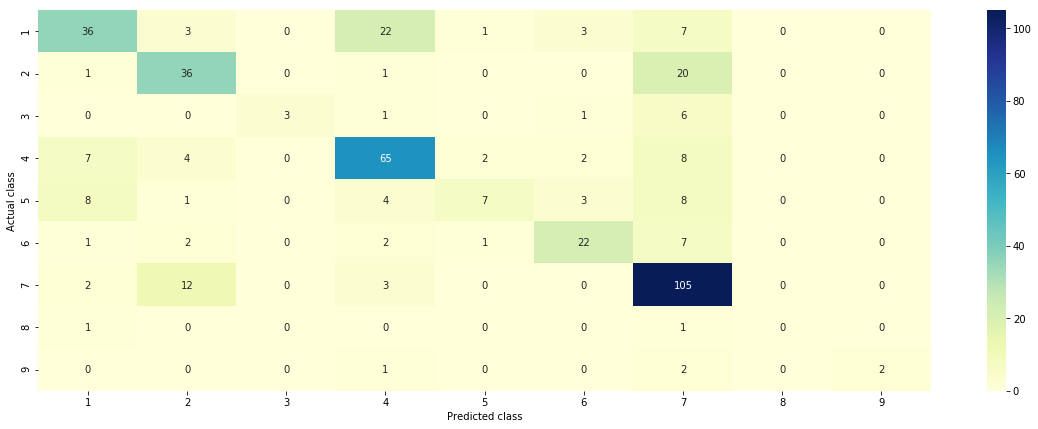

---------------------------------------- Precision matrix(Column Sum = 1) ----------------------------------------


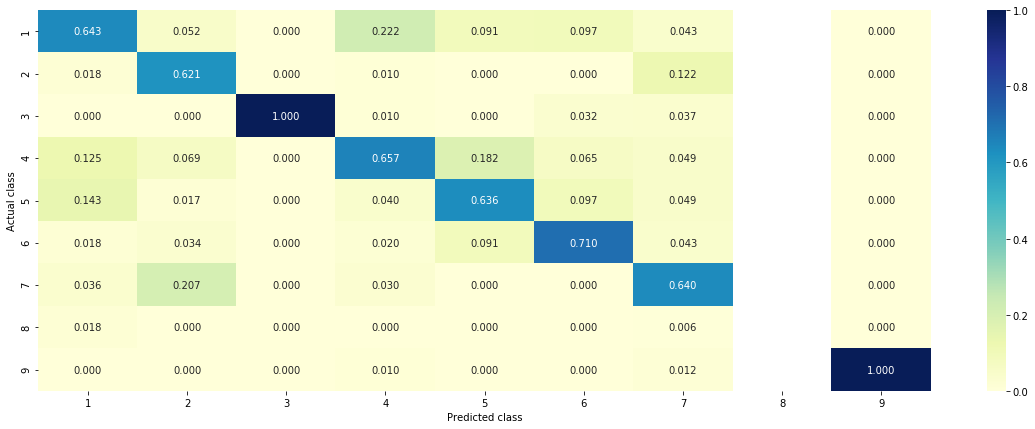

---------------------------------------- Recall matrix(Row Sum = 1) ----------------------------------------


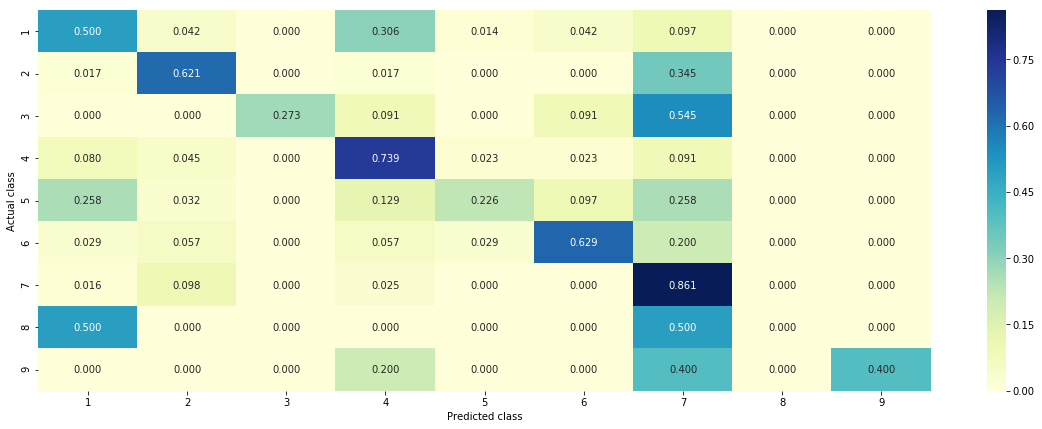

In [79]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', 
                             max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", 
      np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding))

### 2.5.3 Feature Importance

#### 2.5.3.1 Correctly Classified point

In [80]:
for i in range(len(test_y)):
    if test_y[i] == sig_clf.predict(test_x_onehotCoding[i]):
        break
test_point_index = i
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)[:no_feature]
print("-"*50)
get_impfeature_names(indices, test_df['TEXT'].iloc[test_point_index],
                     test_df['Gene'].iloc[test_point_index],
                     test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0662 0.0355 0.2115 0.44   0.0686 0.1299 0.0363 0.006  0.0061]]
Actual Class : 4
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activation] present in test data point [True]
3 Text feature [oncogenic] present in test data point [True]
4 Text feature [inhibitors] present in test data point [True]
5 Text feature [treatment] present in test data point [True]
7 Text feature [inhibitor] present in test data point [True]
8 Text feature [growth] present in test data point [True]
10 Text feature [activated] present in test data point [True]
11 Text feature [tyrosine] present in test data point [True]
13 Text feature [phosphorylation] present in test data point [True]
14 Text feature [suppressor] present in test data point [True]
17 Text feature [inhibition] present in test data point [True]
18 Text feature [receptor] present in test data point [True]
19 Text featu

#### 2.5.3.2 Inorrectly Classified point

In [81]:
for i in range(len(test_y)):
    if test_y[i] != sig_clf.predict(test_x_onehotCoding[i]):
        break
test_point_index = i
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)[:no_feature]
print("-"*50)
get_impfeature_names(indices, test_df['TEXT'].iloc[test_point_index],
                     test_df['Gene'].iloc[test_point_index],
                     test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0374 0.6911 0.0116 0.0231 0.0335 0.0339 0.1608 0.0044 0.0041]]
Actual Class : 6
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activation] present in test data point [True]
2 Text feature [activating] present in test data point [True]
4 Text feature [inhibitors] present in test data point [True]
5 Text feature [treatment] present in test data point [True]
6 Text feature [akt] present in test data point [True]
8 Text feature [growth] present in test data point [True]
11 Text feature [tyrosine] present in test data point [True]
12 Text feature [therapy] present in test data point [True]
13 Text feature [phosphorylation] present in test data point [True]
18 Text feature [receptor] present in test data point [True]
19 Text feature [proliferation] present in test data point [True]
22 Text feature [trials] present in test data point [True]
27 Text feature [trea

### 2.5.3. Hyper paramter tuning (With Response Coding)

In [82]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, 
                                     random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
best_n_estimators_rf_response = alpha[int(best_alpha/4)]
best_max_depth_rf_response = max_depth[int(best_alpha%4)]
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', 
                             max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
rf_response_train_loss = log_loss(y_train, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:", rf_response_train_loss)
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
rf_response_cv_loss = log_loss(y_cv, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:", rf_response_cv_loss)
predict_y = sig_clf.predict_proba(test_x_responseCoding)
rf_response_test_loss = log_loss(y_test, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:", rf_response_test_loss)

for n_estimators = 10 and max depth =  2
Log Loss : 2.049891660430089
for n_estimators = 10 and max depth =  3
Log Loss : 1.7188787836977744
for n_estimators = 10 and max depth =  5
Log Loss : 1.6298158154697289
for n_estimators = 10 and max depth =  10
Log Loss : 2.1249815082500905
for n_estimators = 50 and max depth =  2
Log Loss : 1.7414236900985995
for n_estimators = 50 and max depth =  3
Log Loss : 1.4542849540304905
for n_estimators = 50 and max depth =  5
Log Loss : 1.4347333677001912
for n_estimators = 50 and max depth =  10
Log Loss : 1.6439320653151033
for n_estimators = 100 and max depth =  2
Log Loss : 1.5868445149184316
for n_estimators = 100 and max depth =  3
Log Loss : 1.49906201874446
for n_estimators = 100 and max depth =  5
Log Loss : 1.3545574569212704
for n_estimators = 100 and max depth =  10
Log Loss : 1.6459304732472626
for n_estimators = 200 and max depth =  2
Log Loss : 1.6370347412463881
for n_estimators = 200 and max depth =  3
Log Loss : 1.4914527016844825


### 2.5.4 Testing model with best hyper parameters (Response Coding)

Log Loss : 1.3466646884358446
Number of missclassified point : 0.46226415094339623
---------------------------------------- Confusion matrix ----------------------------------------


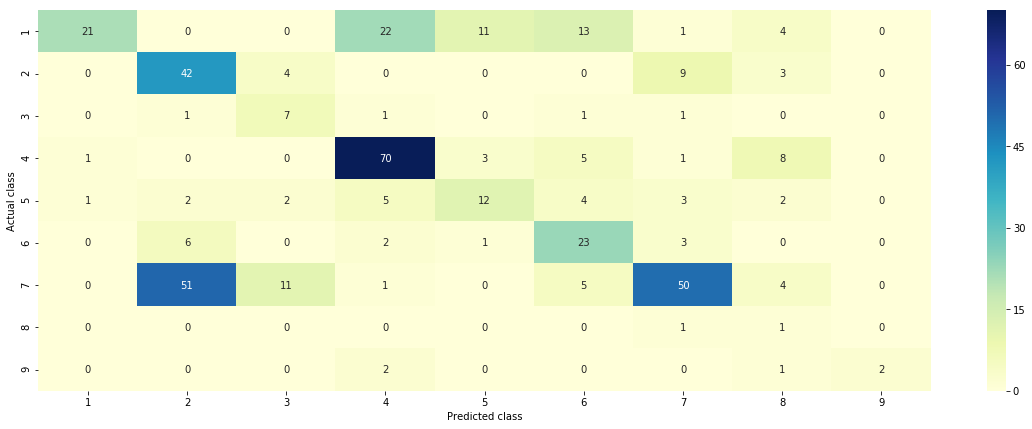

---------------------------------------- Precision matrix(Column Sum = 1) ----------------------------------------


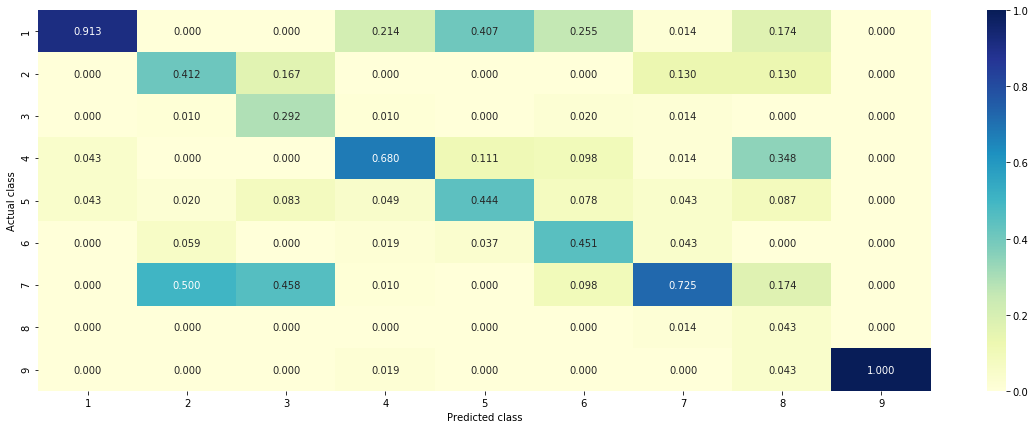

---------------------------------------- Recall matrix(Row Sum = 1) ----------------------------------------


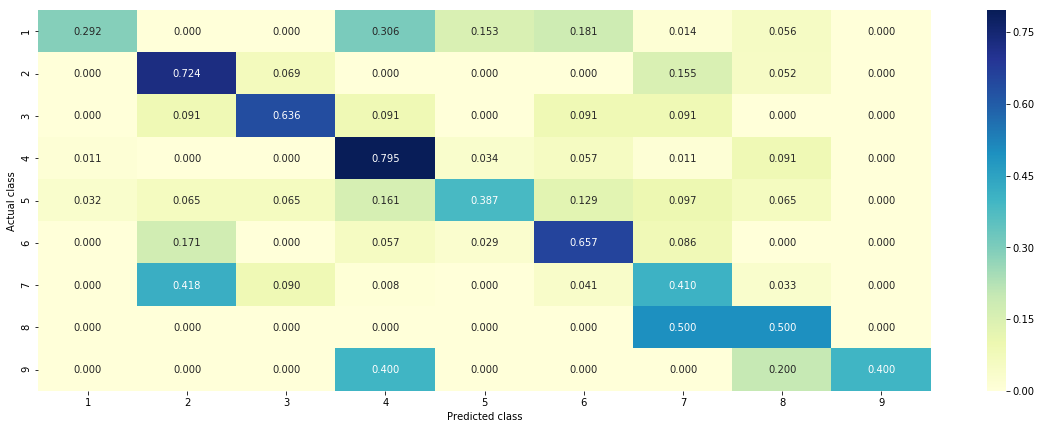

In [83]:
sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", 
      np.count_nonzero((sig_clf.predict(cv_x_responseCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_responseCoding))

### 2.5.5 Feature Importance

#### 2.5.5.1 Correctly Classified point

In [84]:
for i in range(len(test_y)):
    if test_y[i] == sig_clf.predict(test_x_responseCoding[i].reshape(1, -1)):
        break
test_point_index = i
no_feature = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1, -1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1, -1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)[:no_feature]
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 5
Predicted Class Probabilities: [[0.0888 0.0067 0.1061 0.0543 0.5216 0.2026 0.0039 0.0081 0.0079]]
Actual Class : 5
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature


#### 2.5.5.2 Incorrectly Classified point

In [85]:
for i in range(len(test_y)):
    if test_y[i] != sig_clf.predict(test_x_responseCoding[i].reshape(1, -1)):
        break
test_point_index = i
no_feature = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1, -1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1, -1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)[:no_feature]
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 6
Predicted Class Probabilities: [[0.0286 0.0052 0.2918 0.0536 0.2614 0.3432 0.0028 0.0066 0.0067]]
Actual Class : 4
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature


## 2.6 Stack the Models

### 2.6.1 Testing with Hyperparameter tuning

In [86]:
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10]
clf1 = SGDClassifier(alpha = 0.001, penalty = "l2", loss = "log", class_weight = "balanced")
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method = "sigmoid")

clf2 = SGDClassifier(alpha = 1, penalty = "l2", loss = "hinge", class_weight = "balanced")
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method = "sigmoid")

clf3 = MultinomialNB(alpha = 0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method = "sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression : Log Loss : %0.2f"% \
      (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support Vector Machines : Log Loss : %0.2f"% \
      (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss : %0.2f"% \
      (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))

print("-"*50)
best_error = 999
best_alpha = 0.0001
for i in alpha:
    lr = LogisticRegression(C = i)
    sclf = StackingClassifier(classifiers = [sig_clf1, sig_clf2, sig_clf3], meta_classifier = lr,
                             use_probas = True)
    sclf.fit(train_x_onehotCoding, train_y)
    log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    print("Stacking Classifier : for the value of alpha : %f Log Loss : %0.3f"% \
          (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    if log_error < best_error:
        best_error = log_error
        best_alpha = i
best_alpha_stack = best_alpha

Logistic Regression : Log Loss : 1.05
Support Vector Machines : Log Loss : 1.49
Naive Bayes : Log Loss : 1.20
--------------------------------------------------
Stacking Classifier : for the value of alpha : 0.000100 Log Loss : 2.175
Stacking Classifier : for the value of alpha : 0.001000 Log Loss : 2.011
Stacking Classifier : for the value of alpha : 0.010000 Log Loss : 1.433
Stacking Classifier : for the value of alpha : 0.100000 Log Loss : 1.046
Stacking Classifier : for the value of alpha : 1.000000 Log Loss : 1.130
Stacking Classifier : for the value of alpha : 10.000000 Log Loss : 1.352


### 2.6.2 Testing the model with best Hyper parameters

Log loss (train) on the stacking classifier : 0.6281794241998568
Log loss (CV) on the stacking classifier : 1.0529797348323195
Log loss (test) on the stacking classifier : 1.110699491095966
Number of missclassified point : 0.33867735470941884
---------------------------------------- Confusion matrix ----------------------------------------


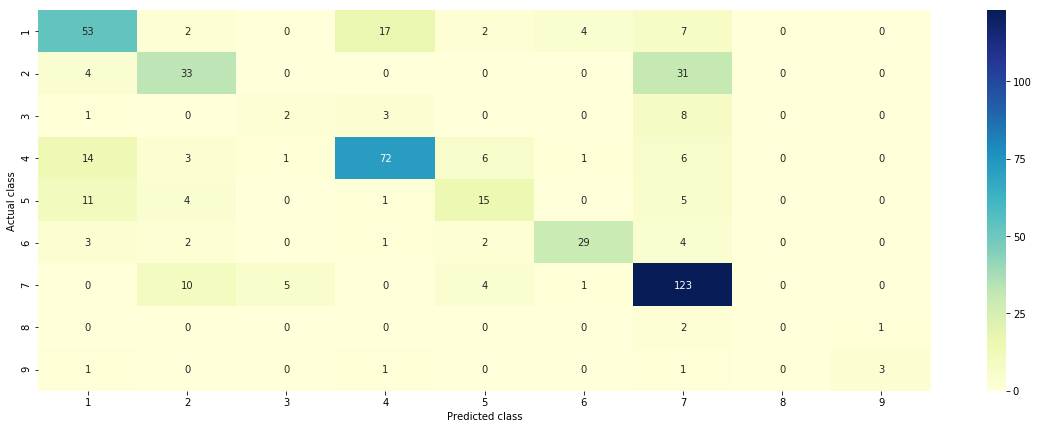

---------------------------------------- Precision matrix(Column Sum = 1) ----------------------------------------


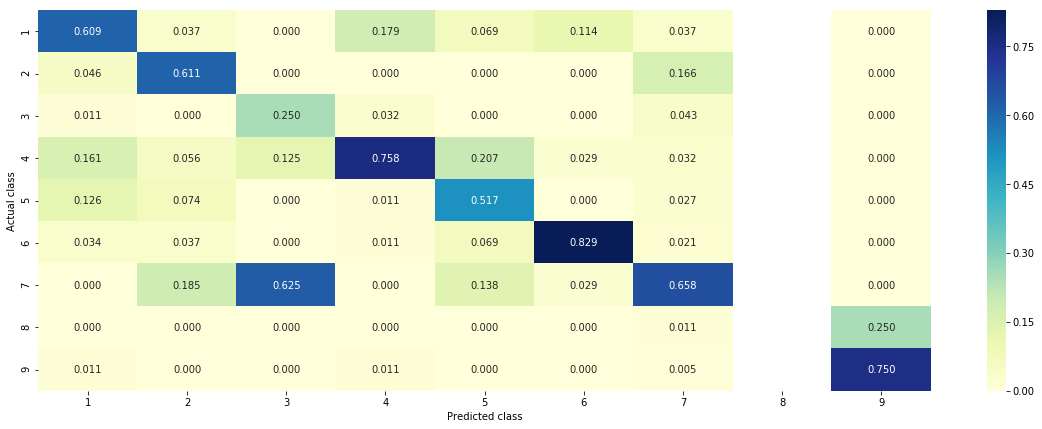

---------------------------------------- Recall matrix(Row Sum = 1) ----------------------------------------


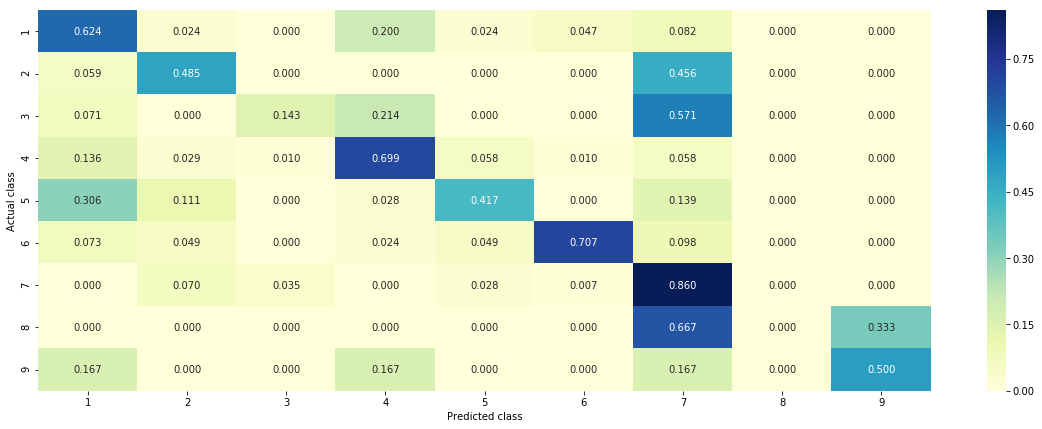

In [87]:
lr = LogisticRegression(C = best_alpha)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier = lr, 
                          use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

stack_train_loss = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :", stack_train_loss)

stack_cv_loss = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :", stack_cv_loss)

stack_test_loss = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :", stack_test_loss)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- \
                                                            test_y))/test_y.shape[0])
plot_confusion_matrix(test_y, sclf.predict(test_x_onehotCoding))

### 2.6.3 Maximum Voting Classifier

Log loss (train) on the VotingClassifier : 0.8010398088060978
Log loss (CV) on the VotingClassifier : 1.0653094772382674
Log loss (test) on the VotingClassifier : 1.1018671963273143


C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Number of missclassified point : 0.3406813627254509


C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


---------------------------------------- Confusion matrix ----------------------------------------


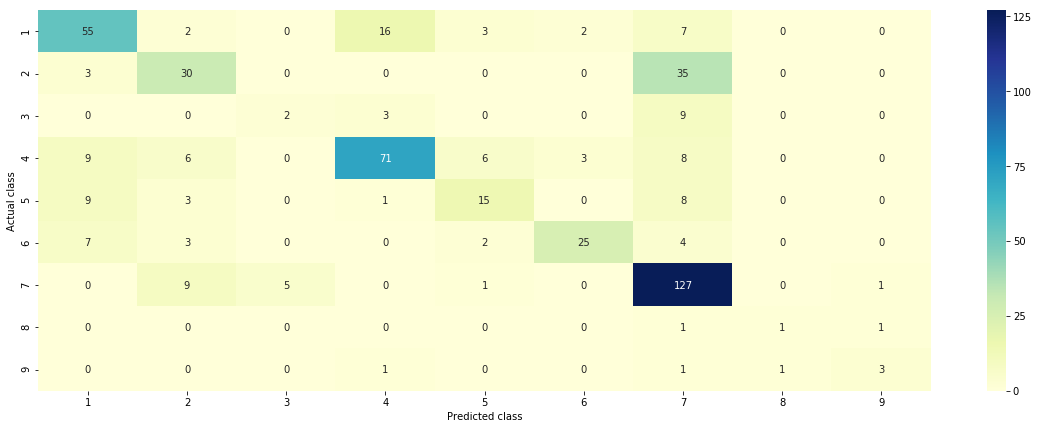

---------------------------------------- Precision matrix(Column Sum = 1) ----------------------------------------


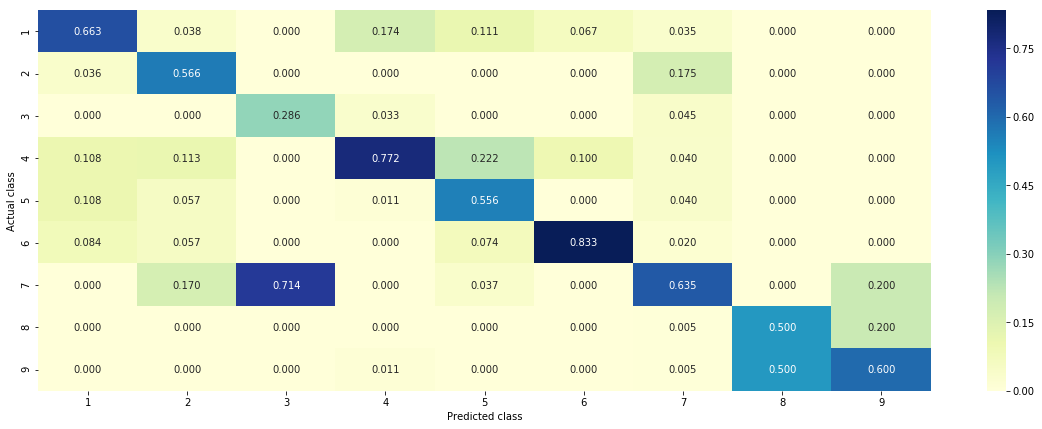

---------------------------------------- Recall matrix(Row Sum = 1) ----------------------------------------


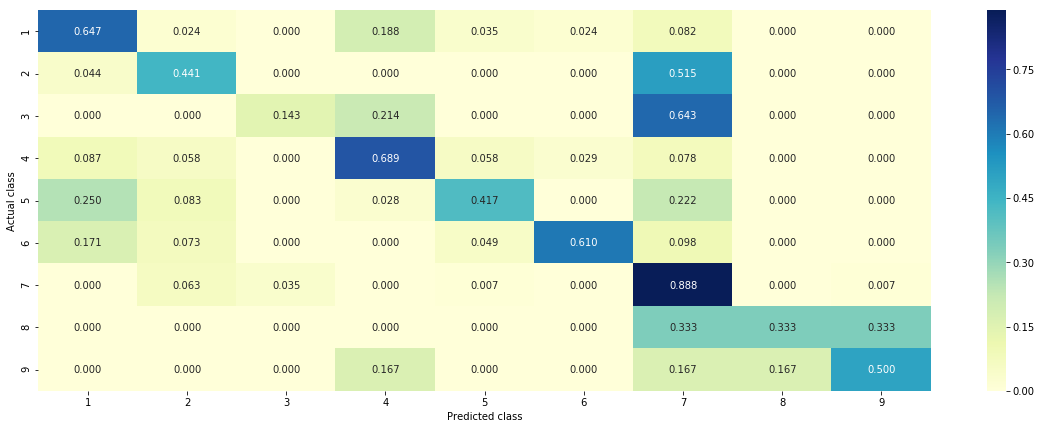

In [88]:
clf1 = SGDClassifier(alpha = 0.001, penalty = "l2", loss = "log", class_weight = "balanced")
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method = "sigmoid")

clf2 = SGDClassifier(alpha = 1, penalty = "l2", loss = "hinge", class_weight = "balanced")
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method = "sigmoid")

clf3 = RandomForestClassifier(n_estimators = 1000, max_depth = 10, n_jobs=-1)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method = "sigmoid")

vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], 
                                                                                voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
voting_train_loss = log_loss(train_y, vclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the VotingClassifier :", voting_train_loss)
voting_cv_loss = log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the VotingClassifier :", voting_cv_loss)
voting_test_loss = log_loss(test_y, vclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the VotingClassifier :", voting_test_loss)
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y, vclf.predict(test_x_onehotCoding))

Assignment 4

In [89]:
data = pd.read_csv("training_variants")
print("Number of data points :", data.shape[0])
print("Number of features :", data.shape[1])
print("Features :", data.columns.values)
data.head()

Number of data points : 3321
Number of features : 4
Features : ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [90]:
data_text = pd.read_csv("training_text", sep = "\|\|", engine = "python", names = ["ID", "TEXT"], 
                                                                          skiprows = 1)
print("Number of data points :", data_text.shape[0])
print("Number of features :", data_text.shape[1])
print("Features :", data_text.columns.values)
data_text.head()

Number of data points : 3321
Number of features : 2
Features : ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [91]:
result = pd.merge(data, data_text, on ="ID", how = "left")
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [92]:
result.loc[result["TEXT"].isnull(), "TEXT"] = result["Gene"]+" "+result["Variation"]

In [93]:
stop_words = set(stopwords.words("english"))
stop_words.update(["mutations", "cell", "cells", "mutation", "fig", "cancer", "figure", 
                                                                       "patients", "also"])
#result["Upper_count"] = result["TEXT"].\
                            #progress_apply(lambda x : len([w for w in x.split() if w.isupper()]))
#result['Stopwords_count'] = result['TEXT'].\
                        #progress_apply(lambda x: len([x for x in x.split() if x in stop_words]))

In [94]:
def nlp_preprocessing(total_text):
    if (type(total_text) is not int) and (type(total_text) is not float):
        string = ""
        
        # Replacing special characters with a space
        total_text = re.sub("\W+", " ", total_text)
        # Replacing multiple space with a single space
        total_text = re.sub("\s+", " ", total_text)
        # Replacing html tags with a space
        soup = BeautifulSoup(total_text, "lxml")
        total_text = soup.get_text()
        # Replacing urls with a space
        total_text = re.sub(r"http\S+", " ", total_text)
        # Converting all the characters to lower case
        total_text = total_text.lower()
        
        for word in total_text.split():
            if word not in stop_words:
                string += word + " "
                
        return string
    return ""

In [95]:
result["TEXT"] = result["TEXT"].progress_apply(nlp_preprocessing)
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small lung nsclc heter...
2,2,CBL,Q249E,2,abstract background non small lung nsclc heter...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic monomeric casitas b lineage lymphoma...


In [96]:
#def avg_word(sentence):
 #   words = sentence.split()
  #  return (sum(len(word) for word in words)/len(words))

#result['Avg_word_length'] = result['TEXT'].progress_apply(lambda x: avg_word(x))

In [97]:
#result["Text_Length"] = result["TEXT"].str.len()
#result["Word_Count"] = result["TEXT"].progress_apply(lambda x : len(x.split()))
#result["Digit_count"] = result["TEXT"].\
                            #progress_apply(lambda x : len([w for w in x.split() if any(char.isdigit() for char in w)]))
#result.head()

In [98]:
result[result["ID"] == 1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,fanca s1088f


In [141]:
y_true = result["Class"].values
result.Gene = result.Gene.str.replace("\s+", "_")
result.Variation = result.Variation.str.replace("\s+", "_")

x_train, test_df, y_train, y_test = train_test_split(result, y_true, 
                                                     stratify = y_true, test_size = 0.20)
train_df, cv_df, y_train, y_cv = train_test_split(x_train, y_train, 
                                                  stratify = y_train, test_size = 0.20)

In [142]:
# one hot encoding of gene feature
vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = vectorizer.fit_transform(train_df["Gene"])
test_gene_feature_onehotCoding = vectorizer.transform(test_df["Gene"])
cv_gene_feature_onehotCoding = vectorizer.transform(cv_df["Gene"])
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])
# one hot coding for text feature
vectorizer = TfidfVectorizer(min_df = 3, max_features = 1500, ngram_range = (1, 4))
train_text_feature_onehotCoding = vectorizer.fit_transform(train_df["TEXT"])
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis = 0)
test_text_feature_onehotCoding = vectorizer.transform(test_df["TEXT"])
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis = 0)
cv_text_feature_onehotCoding = vectorizer.transform(cv_df["TEXT"])
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis = 0)

In [143]:
# here hstack is imported from scipy.sparse not from np
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding, train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding, test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding, cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
#train_x_onehotCoding = hstack((train_x_onehotCoding, \
                               #train_df[["Upper_count", "Stopwords_count","Avg_word_length", 
                                         #"Text_Length", "Word_Count", "Digit_count"]].values)).tocsr()
train_y = np.array(list(train_df["Class"]))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
#test_x_onehotCoding = hstack((test_x_onehotCoding, \
                               #test_df[["Upper_count", "Stopwords_count","Avg_word_length", 
                                         #"Text_Length", "Word_Count", "Digit_count"]].values)).tocsr()
test_y = np.array(list(test_df["Class"]))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
#cv_x_onehotCoding = hstack((cv_x_onehotCoding, \
                               #cv_df[["Upper_count", "Stopwords_count","Avg_word_length", 
                                         #"Text_Length", "Word_Count", "Digit_count"]].values)).tocsr()
cv_y = np.array(list(cv_df["Class"]))

In [144]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 3691)
(number of data points * number of features) in test data =  (665, 3691)
(number of data points * number of features) in cross validation data = (532, 3691)


for alpha = 1e-05
Log Loss : 1.091966021598375
for alpha = 0.0001
Log Loss : 1.0403411059092478
for alpha = 0.0002
Log Loss : 1.0273361765777347
for alpha = 0.00025
Log Loss : 1.0236001843437859
for alpha = 0.0003
Log Loss : 1.0316085830190176
for alpha = 0.001
Log Loss : 1.0704740785933469
for alpha = 0.01
Log Loss : 1.259050126996163
for alpha = 0.1
Log Loss : 1.7822922615481842
for alpha = 1
Log Loss : 1.915608663811069


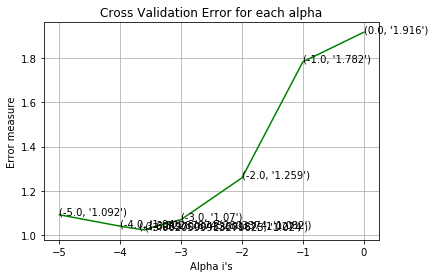

For values of best alpha =  0.00025 The train log loss is: 0.5058976783394307
For values of best alpha =  0.00025 The cross validation log loss is: 1.0250277061098223
For values of best alpha =  0.00025 The test log loss is: 0.9838655686755144


In [145]:
#alpha = [10 ** x for x in range(-6, 3)]
#alpha = [0.0001, 0.001, 0.01, 0.1, 1, 3, 5, 7, 10, 30, 100]
alpha = [0.00001, 0.0001, 0.0002, 0.00025, 0.0003, 0.001, 0.01, 0.1, 1]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log')
    #clf = LogisticRegression(class_weight='balanced', C=i, penalty='l2')
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((np.log10(alpha[i]),str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
best_alpha_assignment = alpha[best_alpha]
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
assignment_train_loss = log_loss(y_train, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", assignment_train_loss)
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
assignment_cv_loss = log_loss(y_cv, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:", assignment_cv_loss)
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
assignment_test_loss = log_loss(y_test, predict_y, labels=clf.classes_)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", assignment_test_loss)

Log Loss : 1.0250277061098223
Number of missclassified point : 0.3308270676691729
---------------------------------------- Confusion matrix ----------------------------------------


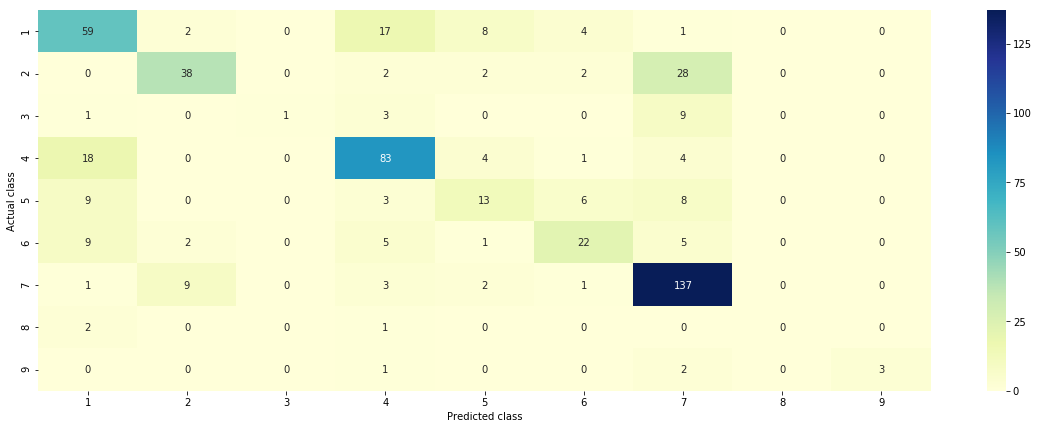

---------------------------------------- Precision matrix(Column Sum = 1) ----------------------------------------


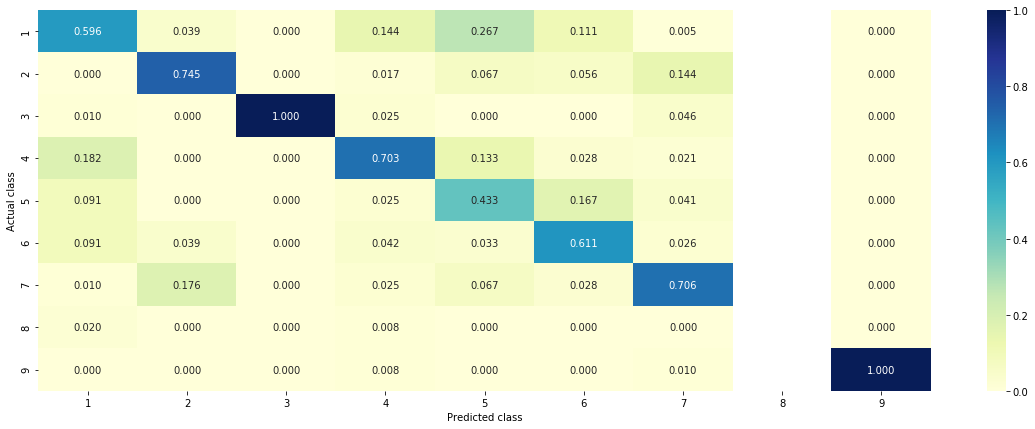

---------------------------------------- Recall matrix(Row Sum = 1) ----------------------------------------


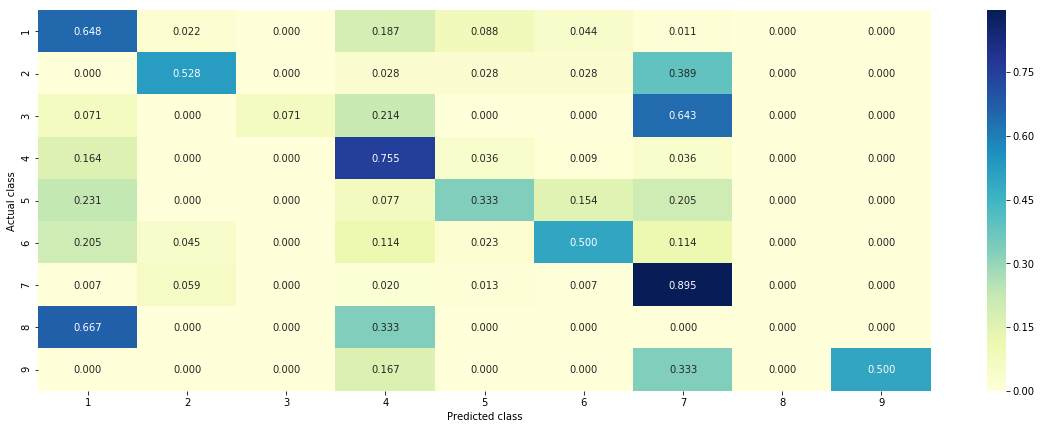

In [146]:
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", 
      np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding))

# Conclusions

In [147]:
p = PrettyTable(show_row_numbers = True, field_names = ['Model', "Analysis", 'Vectorizer',"Hyperparameters", 
                               "Train Logloss", "Test Logloss"], padding_width = 0)

p.add_row(["Random", "-", "-", "-", round(random_train_loss, 3), round(random_test_loss, 3)])
p.add_row(["Logistic", "Univariate(Gene)", "CountVectorizer", "alpha = "+str(best_alpha_gene), round(gene_train_loss, 3), round(gene_test_loss, 3)])
p.add_row(["Logistic", "Univariate(Variation)", "CountVectorizer", "alpha = "+str(best_alpha_variation), variation_train_loss, variation_test_loss])
p.add_row(["Logistic", "Univariate(Text)", "TfidfVectorizer", "alpha = "+str(best_alpha_text), text_train_loss, text_test_loss])
p.add_row(["Naive Bayes", "Multivariate", "TfidfVectorizer", "alpha = "+str(best_alpha_nb), nb_train_loss, nb_test_loss])
p.add_row(["KNN", "Multivariate", "TfidfVectorizer", "alpha = "+str(best_alpha_knn), knn_train_loss, knn_test_loss])
p.add_row(["Logistic"+"\n"+"(With Class Balancing)", "Multivariate", "TfidfVectorizer", "alpha = "+str(best_alpha_b_log), log_b_train_loss, log_b_test_loss])
p.add_row(["Logistic"+"\n"+"(With Class Balancing)", "Multivariate", "CountVectorizer", "alpha = "+str(best_alpha_log_bow), log_bow_train_loss, log_bow_test_loss])
p.add_row(["Logistic"+"\n"+"(Without Class Balancing)", "Multivariate", "TfidfVectorizer", "alpha = "+str(best_alpha_log), log_train_loss, log_test_loss])
p.add_row(["SVM"+"\n"+"(With Class Balancing)", "Multivariate", "TfidfVectorizer", "alpha = "+str(best_alpha_svm), svm_train_loss, svm_test_loss])
p.add_row(["Random Forest"+"\n"+"(With Onehot Encoded Features)", "Multivariate", "TfidfVectorizer", "n_estimators = "+str(best_n_estimators_rf_onehot)+"\n"+"max_depth = "+str(best_max_depth_rf_onehot), rf_onehot_train_loss, rf_onehot_test_loss])
p.add_row(["Random Forest"+"\n"+"(With Response Coded Features)", "Multivariate", "TfidfVectorizer", "n_estimators = "+str(best_n_estimators_rf_response)+"\n"+"max_depth = "+str(best_max_depth_rf_response), rf_response_train_loss, rf_response_test_loss])
p.add_row(["Stacking Classifier", "Multivariate", "TfidfVectorizer", "alpha = "+str(best_alpha_stack), stack_train_loss, stack_test_loss])
p.add_row(["Voting Classifier", "Multivariate", "TfidfVectorizer", "-", voting_train_loss, voting_test_loss])
p.add_row(["Logistic"+"\n"+"(Assignment)", "Multivariate", "TfidfVectorizer", "alpha = "+str(best_alpha_assignment), assignment_train_loss, assignment_test_loss])
print(p)

+--------------------------------+-----------------------+-----------------+---------------------+---------------------+--------------------+
|             Model              |        Analysis       |    Vectorizer   |   Hyperparameters   |    Train Logloss    |    Test Logloss    |
+--------------------------------+-----------------------+-----------------+---------------------+---------------------+--------------------+
|             Random             |           -           |        -        |          -          |        2.454        |       2.554        |
|            Logistic            |    Univariate(Gene)   | CountVectorizer |    alpha = 0.0001   |        0.971        |        1.24        |
|            Logistic            | Univariate(Variation) | CountVectorizer |    alpha = 0.001    | 0.21221112682863233 | 2.259203034531463  |
|            Logistic            |    Univariate(Text)   | TfidfVectorizer |    alpha = 0.001    |  0.6674728910230454 | 1.1645627889959056 |
|     

# Summary

This is the first case study that I have solved in medical domain. It was an interesting one because it taught me how to apply different methods like getting most important features, constructing response encoded features etc. which I had studied theoratically in a real world problem. Let us go through step by step approach on how I went onto solve this problem.

* Step-1--> There were two files, one containning 3 features(Gene, Variation and Class) the other one containing the text data. I started exploring them.
* Step-2--> To do deeper analysis I realised that the text feature need to be preprocessed..
* Step-3--> After preprocessing the text feature I merged the two files containing features into one dataframe and splitted the dataframe into train, cv and test containning 2398, 424, 499 points respectively.
* Step-4--> After splitting I tried to analyze the distribution of data points of each class in train, cv and test data and I quickly realized that the data is imbalanced.
* Step-5--> As it was a multiclass classification problem I knew my Key Performance Indicator(KPI is going to be multi class log loss so therefore I decided to train a random model to set an upper bound of my loss. It came out to be 2.5.
* Step-6--> Since I had only 3 features(Gene, Variation, TEXT) I thought of doing univariate analysis of each of them.
* Step-7--> The Gene feature was a categorical random variable with 242 unique values. Since I was going to apply logistic regression which gives good results on high dimensional data so I decided to do onhot Encoding using CountVectorizer and the log loss that I obtained on test data was arround 1.17 (quite impressive).
* Step-8--> The same analysis I did with Variation feature since it was also a Categorical Random Variable. The test loss I obtained was around 1.8 and train loss was 0.08. Clearly my model was overfitting. But that did not mean that my feature was useless because my test loss was less than the loss of a random model.
* Step-9--> For text feature I did Tfidf featurization and got a loss of 1.14.
* Step-10--> Now I had clear view of my each feature. Now I decided to do multivariate analysis.
* Step-11--> For text data Naive Bayes performs good. So I decided to apply Nive Bayes model for the first time and got a log loss of 1.26. But the percentage of misclassified points was very high, around 40%.
* Step-12--> Since it was a problem related to medical domain I had to provide the information of why I classified a particular point to belong to a particular class. I made a function for this and also provided the probabilities for each class.
* Step-13--> Now I moved to KNN. Here I got a loss of 1.011. Best upto now. But the misclassification ratio was still high.
* Step-14--> I expected that Logistic Regression would work well for my problem because of high dimensionality so I decided to train with two datasets. First with a balanced dataset and other with original(imbalanced) dataset.
* Step-15--> I got slightly different results with both the datasets. With the balanced one I got a loss of 1.05 and for imbalanced dataset I got a loss of 1.09. From this result I concluded that I should use balanced dataset for my next model i.e. linear SVM.
* Step-16--> I also tried to train my text data with CountVectorizer with unigrams and bigrams but the results were poorer than before so I decided to continue with TfidfVectorizer.
* Step-17--> For SVM I got a loss of 1.11 pretty much around what I expected because of their similarity with Logistic Regression.
* Step-18--> Now I moved onto Random Forests. Since RF works well with both small dimensions as well as large ones therefore I decided to train my model first with onehotEncoded features and then with response Coded Features. The results were pretty much same as obtained earlier.
* Step-19--> Then I used Stacking(favourite of kagglers) but could not improve the results though improved percentage of misclassified points upto some extent.
* Step-20--> Then I applied Voting Classifier which gave good results but my target was to reduce the test loss below 1.0.
* Step-21--> Now my target was to get test loss less than 1. For this I removed the frequently occuring words from Text data and did some advance data preprocessing. I also did some feature engineering but that did not helped.
* Step-22--> I traind my text feature with TfidfVectorizer this time with max_features = 1500 and ngram_range = (1, 4). Now when I trained my model with logistic Regression with one hot Encoded Gene and Variation features I got the test loss 0.95. My goal was accomplished and so as this case study. Though the results would have been improved if we had more data but this is what it is.